In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Load library

In [11]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, MobileNetV2, EfficientNetB0, InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Rescaling, RandomRotation, RandomTranslation, RandomZoom, RandomFlip
from sklearn.metrics import multilabel_confusion_matrix, classification_report

# 2. Set Config

In [2]:
# Parameters
IMG_SIZE = (224, 224) 
BATCH_SIZE = 64
EPOCHS = 20
NUM_CLASSES = 16 

# 3. Raw data preprocessing

In [3]:
# Define image augmentation layer
data_augmentation = tf.keras.Sequential([
    Rescaling(1./255),           # Normalize pixel values (0-1)
    RandomRotation(0.2),         # Rotate by ±20%
    RandomTranslation(0.2, 0.2), # Shift width/height by ±20%
    RandomZoom(0.2),             # Zoom in/out by 20%
    RandomFlip("horizontal"),    # Horizontally flip images
])
def load_csv(data_dir):
    """Load CSV and return image paths + multi-labels."""
    csv_path = os.path.join(data_dir, "_classes.csv")
    df = pd.read_csv(csv_path)

    # Construct full image paths
    image_paths = [os.path.join(data_dir, fname) for fname in df["filename"]]
    
    # Extract labels (A, B, C, D) as numpy array
    labels = df.iloc[:, 1:].values.astype(np.float32)  # Convert to float32 for TF
    
    return image_paths, labels

def load_and_preprocess_image(image_path, label, data_augment=False):
    """Load, resize, and normalize an image."""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Change to decode_png if needed
    img = tf.image.resize(img, IMG_SIZE)
    if data_augment:
        img = tf.expand_dims(img, axis=0)            # Add batch dimension

        # Apply data augmentation
        img = data_augmentation(img, training=True)
        img = tf.squeeze(img, axis=0)  # Remove batch dimension

        return img, label
    else:
        img = img / 255.0  # Normalize
        return img, label

def create_dataset(data_dir, data_augment=False):
    """Create TensorFlow dataset from image paths and labels."""
    image_paths, labels = load_csv(data_dir)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augment), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset

## 3.1 Visualize data

In [55]:
# Visualize class distribution
def visualize_class_distribution(labels, class_names=None):
    class_counts = np.sum(labels, axis=0)
    indices = np.arange(len(class_counts))

    if class_names is None:
        class_names = [f"Class {i}" for i in range(len(class_counts))]

    plt.figure(figsize=(12, 6))
    plt.bar(indices, class_counts)
    plt.xticks(indices, class_names, rotation=45)
    plt.ylabel("Number of Samples")
    plt.title("Class Distribution in Dataset")
    plt.tight_layout()
    plt.show()

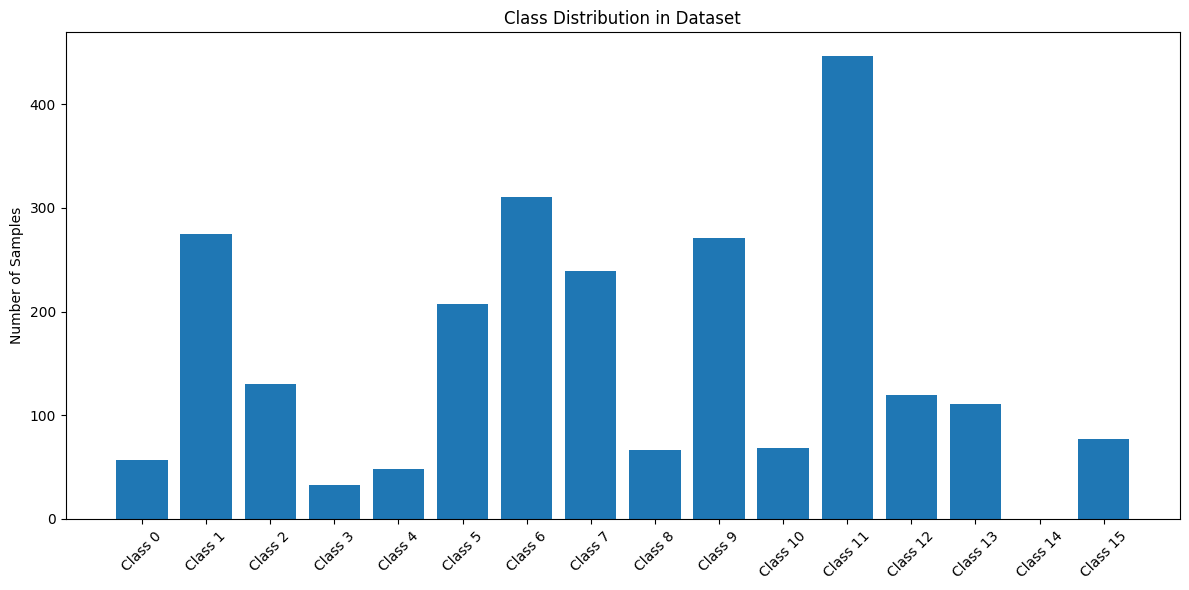

In [56]:
image_paths, labels = load_csv("/kaggle/input/leaf-disease-dataset/train")
visualize_class_distribution(labels)

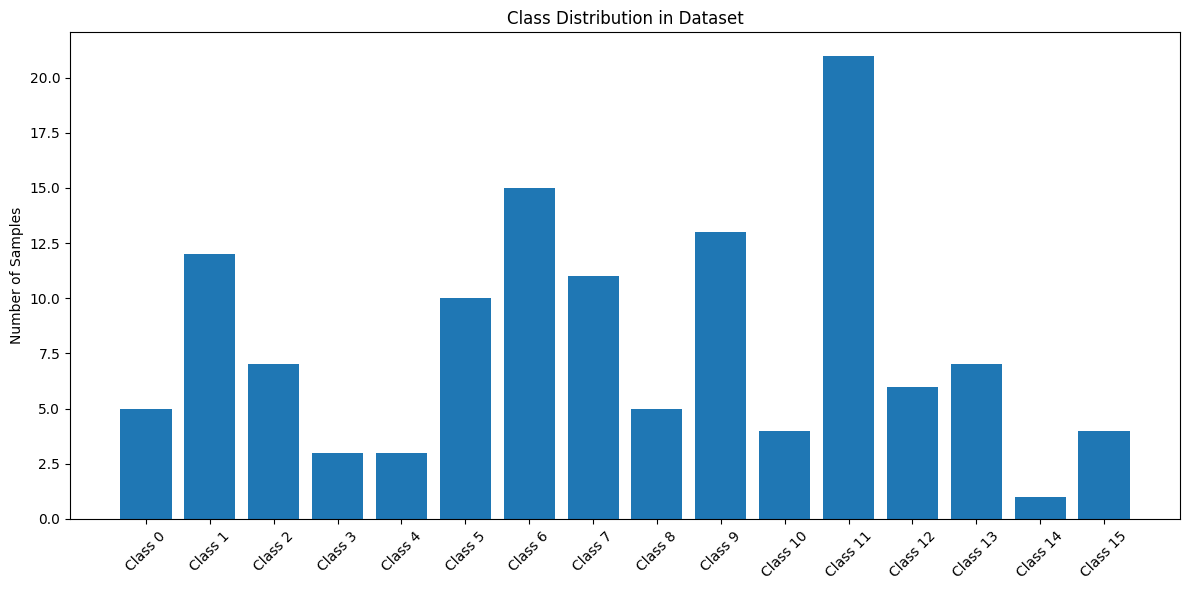

In [57]:
image_paths, labels = load_csv("/kaggle/input/leaf-disease-dataset/test")
visualize_class_distribution(labels)

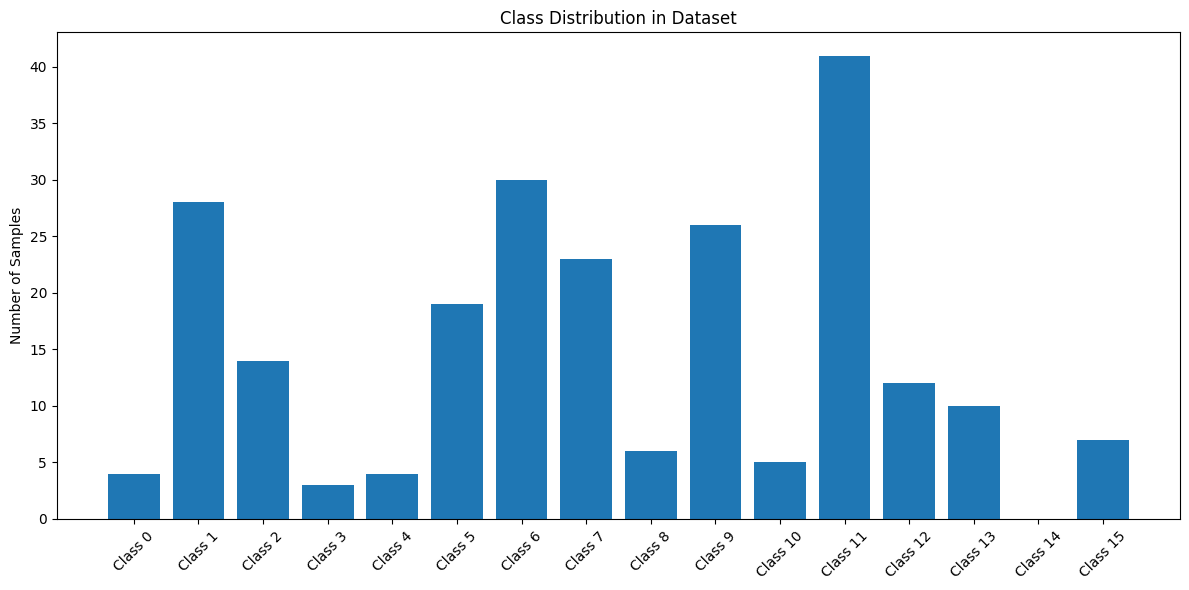

In [58]:
image_paths, labels = load_csv("/kaggle/input/leaf-disease-dataset/valid")
visualize_class_distribution(labels)

# 4. Build model and compile

In [12]:
def build_model(base_model, fine_tune=False, regular=False):
    if fine_tune:
        for layer in base_model.layers[-30:]:
            layer.trainable = True
    else:
        base_model.trainable = False 
    if regular:
        model = tf.keras.Sequential([
                            base_model,
                            GlobalAveragePooling2D(),
                            Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
                            Dropout(0.5),
                            Dense(16, activation='sigmoid')  
                ])
    else:
        model = tf.keras.Sequential([
                          base_model,
                          GlobalAveragePooling2D(),
                          Dense(128, activation="relu"),
                          Dropout(0.5),
                          Dense(16, activation="sigmoid")  
                ])
    model.compile(
          optimizer='adam',
          loss='binary_crossentropy',
          metrics=['accuracy']
          )
    return model

# 5. Training function and Plot

In [35]:
def training(models, train_dataset, val_dataset, test_dataset):
    for name, model in models.items():
        print(f'Training {name}...')
        with tf.device('/GPU:0'):
            history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, verbose=1)
            model.save(f'/kaggle/working/{name}_leaf_disease.h5')
            print(f"Model saved at /kaggle/working/{name}_leaf_disease.h5")
            
        test_loss, test_acc = model.evaluate(test_dataset)
        print(f'Test accuracy: {test_acc*100:.2f}%')
          
        # Generate predictions
        y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)  # Extract labels
        y_pred = model.predict(test_dataset)
        y_pred = (y_pred > 0.5).astype(int) 
        
        # Compute confusion matrix for each class
        cm = multilabel_confusion_matrix(y_true, y_pred)
        
        # Plot confusion matrices
        for i in range(16):
            plt.figure(figsize=(6, 4))
            sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title(f'Confusion Matrix for Class {i}')
            plt.show()
        
        # Print classification report
        print(f'Classification Report for {name}:\n', classification_report(y_true, y_pred))
        plot_history(history)

In [28]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1, 2, figsize = (10, 5))
  fig.suptitle('Training and validation accuracy')

  for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training" + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation" + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')
  plt.show()

# 6. Transfer from ResNet50, MobileNetV2, InceptionNetV3, EfficientNetB0 with no data augmentation


In [29]:
# Load pretrained models
models = {
    'ResNet50': build_model(ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))),
    'MobileNetV2': build_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))),
    'EfficientNetB0': build_model(EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))),
    'InceptionV3': build_model(InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
}

## 6.1 Load data

In [7]:
# Load datasets
train_dataset = create_dataset("/kaggle/input/leaf-disease-dataset/train")
val_dataset = create_dataset("/kaggle/input/leaf-disease-dataset/valid")
test_dataset = create_dataset("/kaggle/input/leaf-disease-dataset/test")

## 6.2 Transfer

Training ResNet50...
Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.1393 - loss: 0.2312 - val_accuracy: 0.1280 - val_loss: 0.2221
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.1441 - loss: 0.2314 - val_accuracy: 0.1280 - val_loss: 0.2218
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.1424 - loss: 0.2311 - val_accuracy: 0.1327 - val_loss: 0.2214
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.1452 - loss: 0.2275 - val_accuracy: 0.1280 - val_loss: 0.2216
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.1494 - loss: 0.2299 - val_accuracy: 0.1280 - val_loss: 0.2214
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.1477 - loss: 0.2286 - val_accuracy: 0.1280 - val_loss: 0.2214
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.1501 - loss: 0.2292 - val_accuracy: 0.1280 - val_loss: 0.2216
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step - accuracy: 0.1582 - loss: 0.22

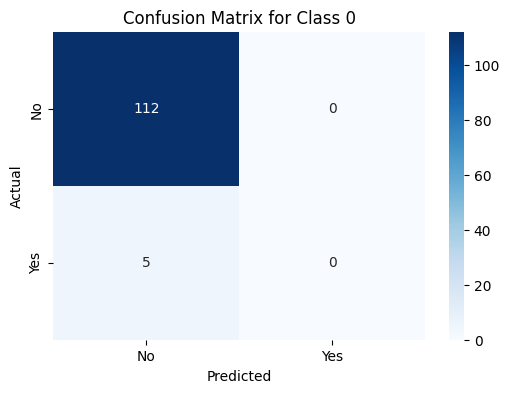

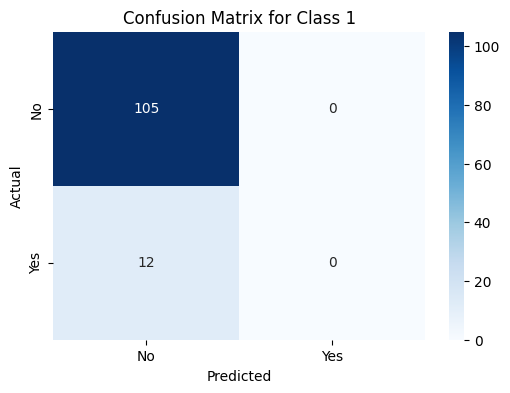

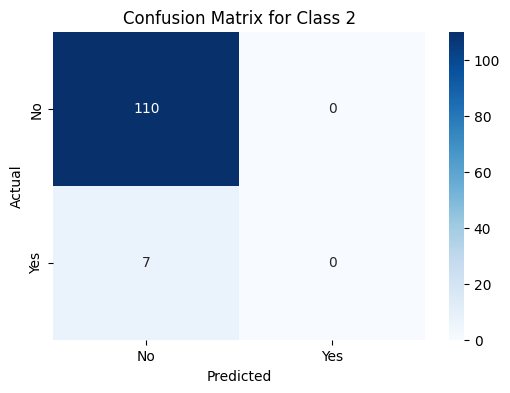

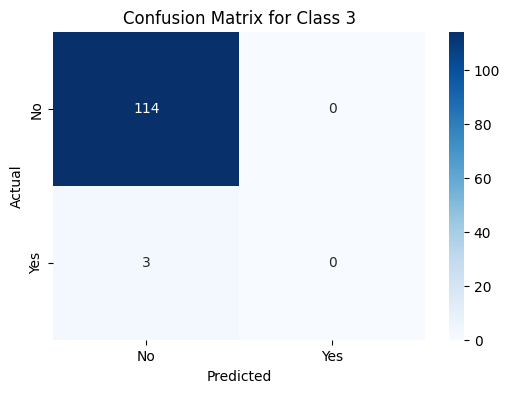

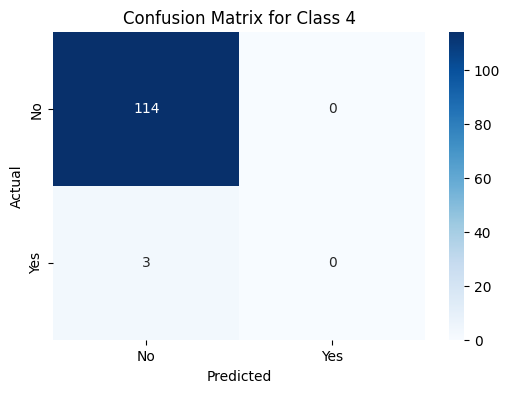

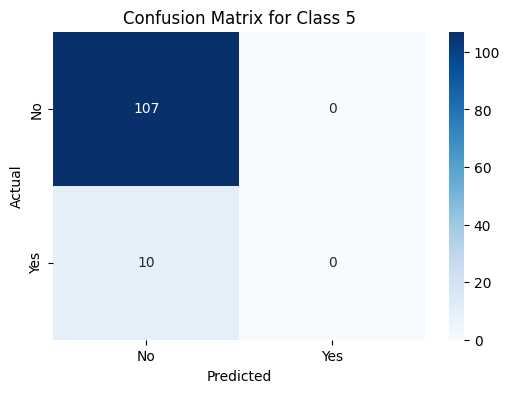

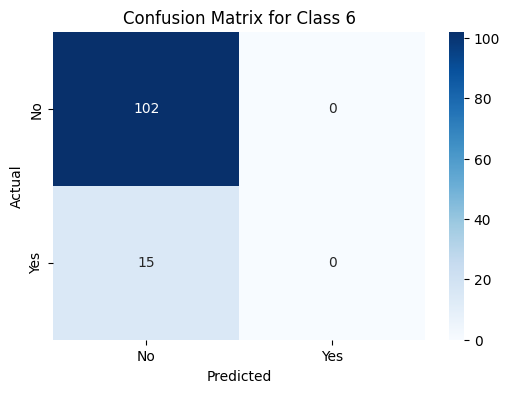

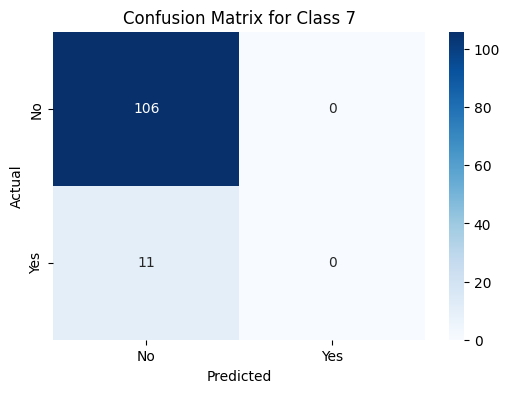

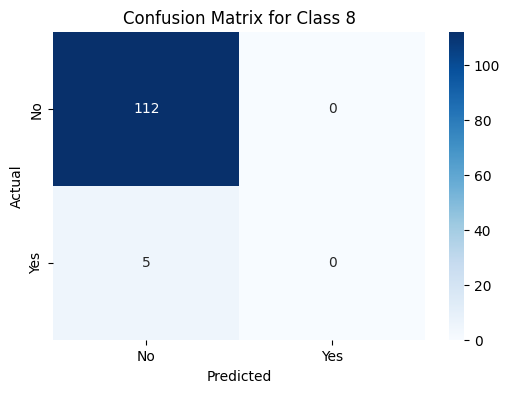

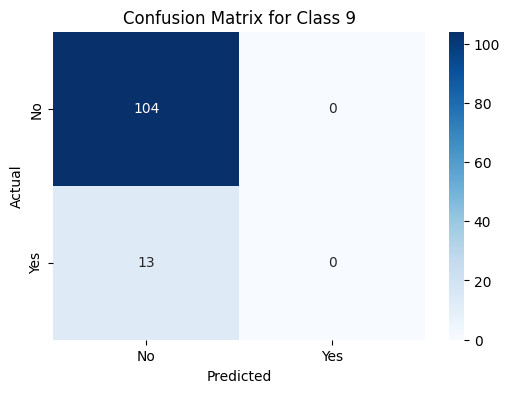

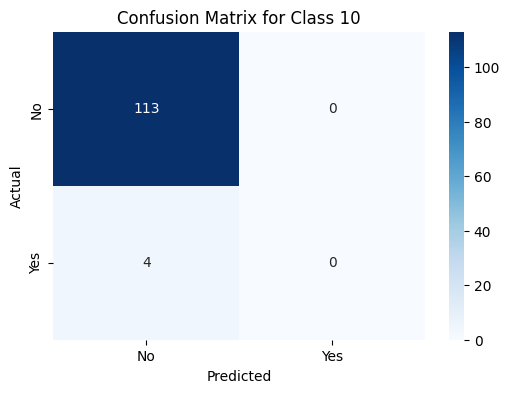

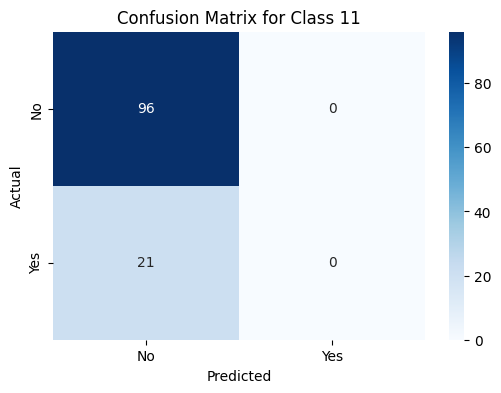

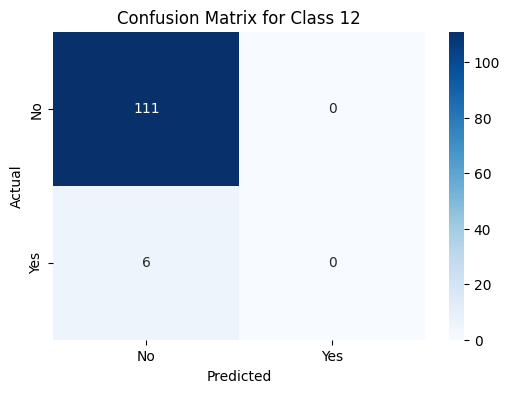

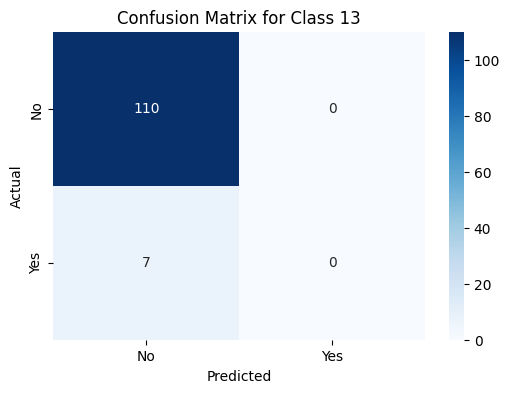

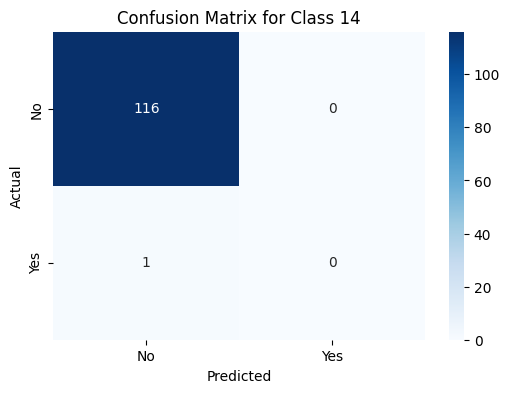

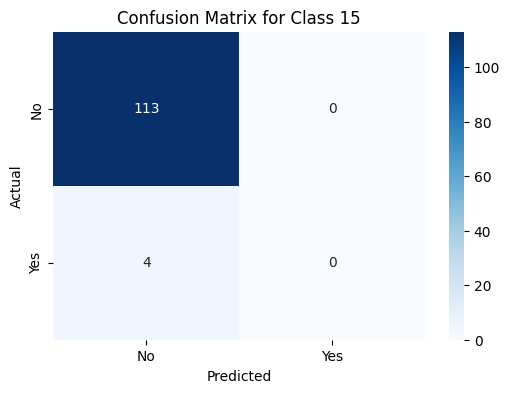

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for ResNet50:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        15
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        13
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00        21
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         4

   micro avg       0.00      0.00      0.00

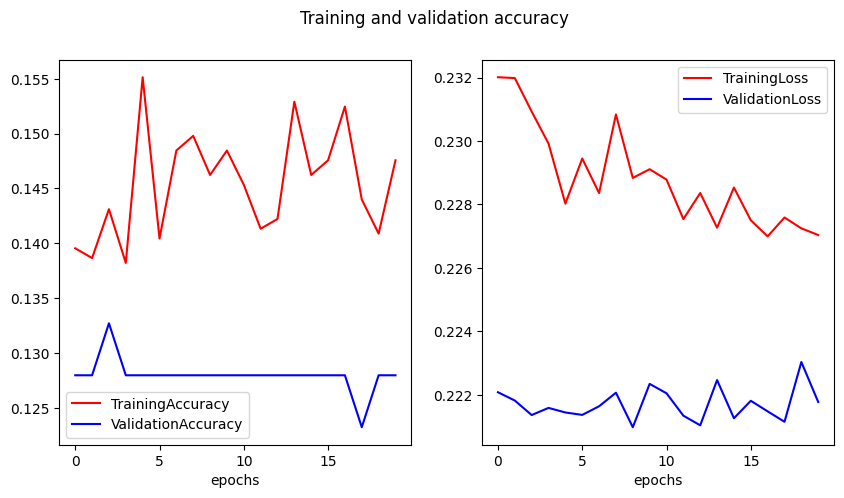

Training MobileNetV2...
Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 348ms/step - accuracy: 0.1144 - loss: 0.4011 - val_accuracy: 0.3555 - val_loss: 0.1958
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.2780 - loss: 0.2248 - val_accuracy: 0.4076 - val_loss: 0.1781
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.4202 - loss: 0.1813 - val_accuracy: 0.4265 - val_loss: 0.1687
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.5184 - loss: 0.1622 - val_accuracy: 0.4692 - val_loss: 0.1621
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.5544 - loss: 0.1430 - val_accuracy: 0.4834 - val_loss: 0.1571
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.5890 - loss: 0.1321 - val_accuracy: 0.4692 - val_loss: 0.1542
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.6318 - loss: 0.1200 - val_accuracy: 0.4550 - val_loss: 0.1531
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.6435 - loss: 0.1134 

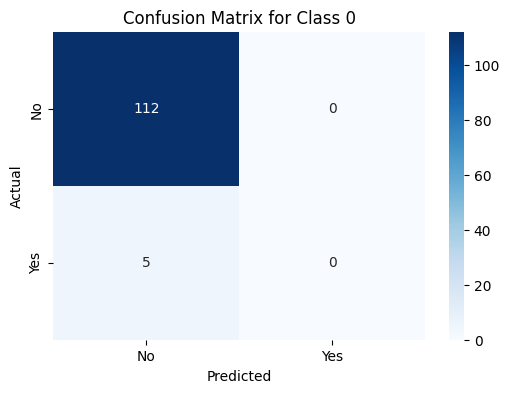

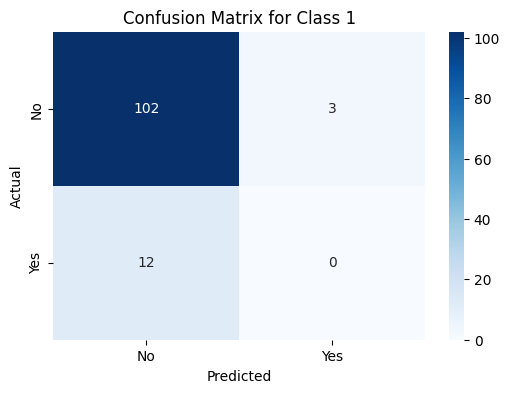

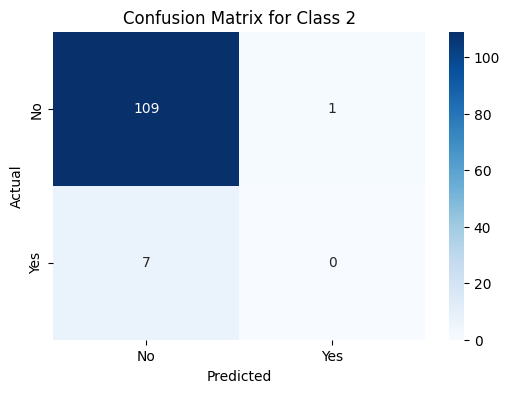

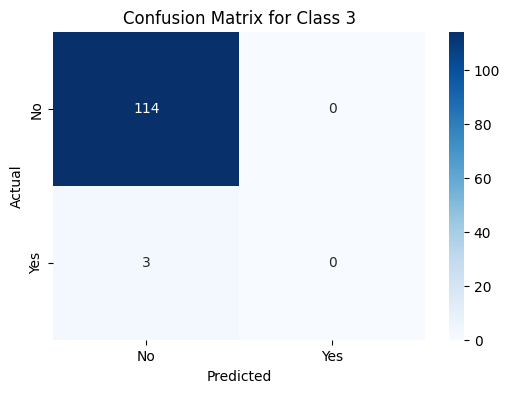

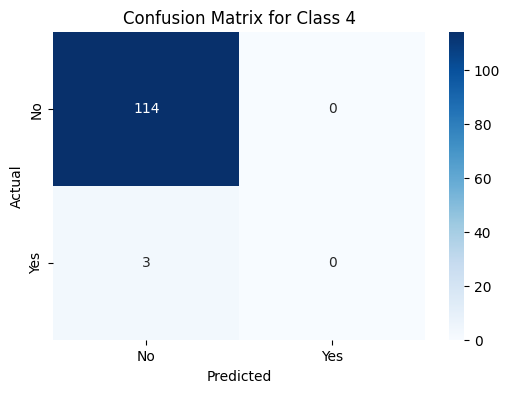

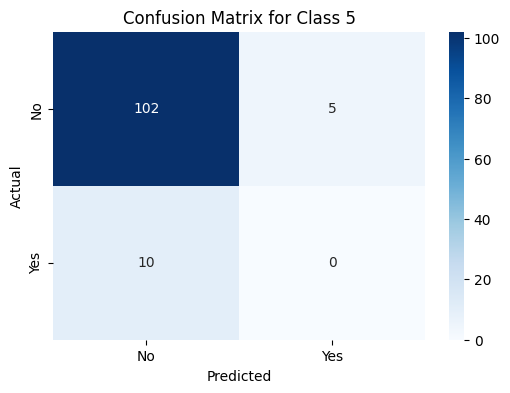

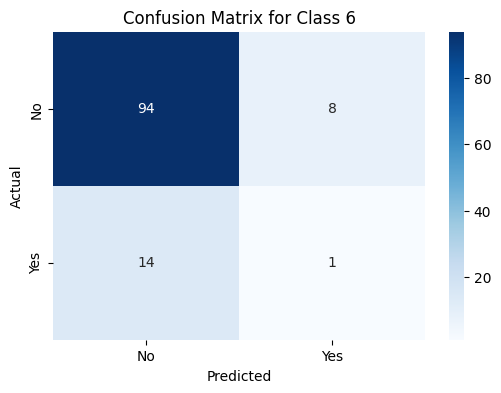

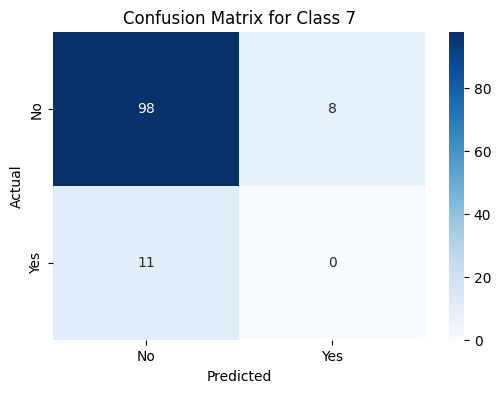

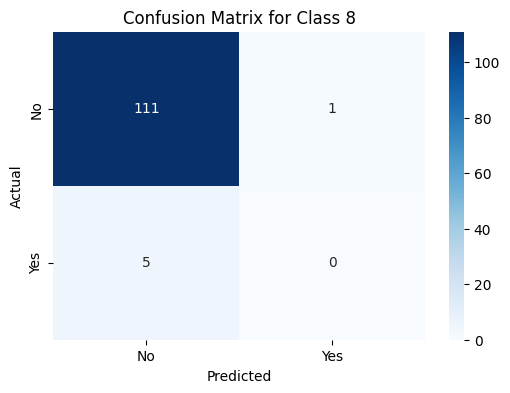

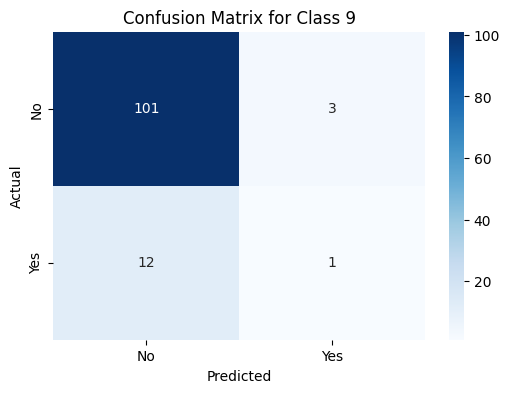

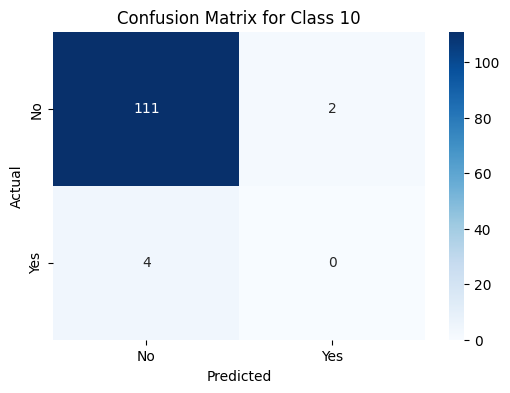

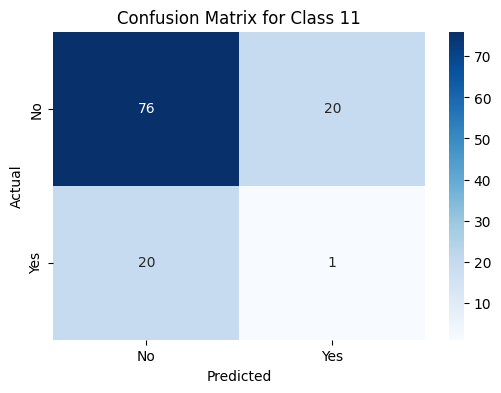

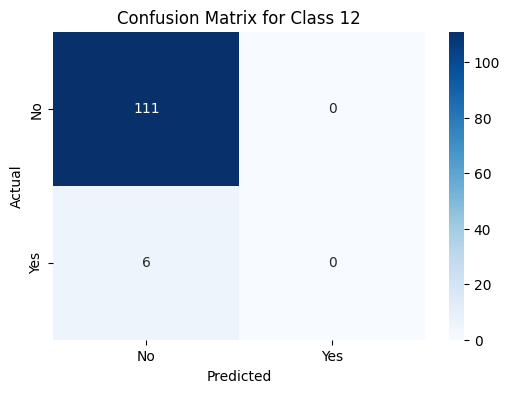

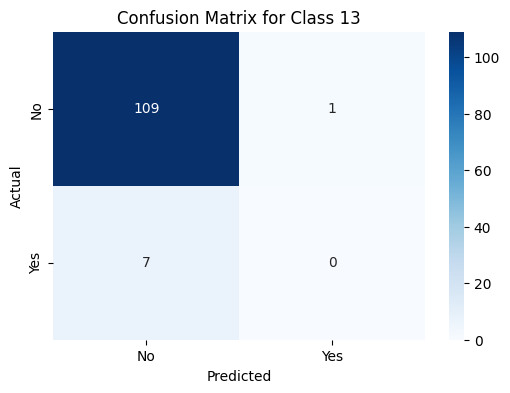

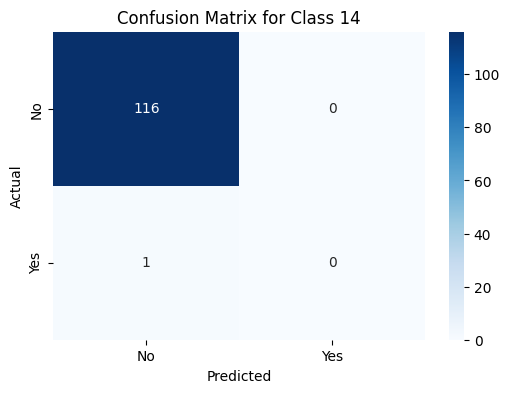

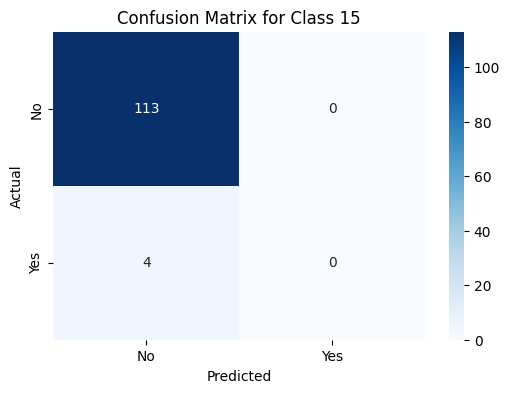

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for MobileNetV2:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        10
           6       0.11      0.07      0.08        15
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00         5
           9       0.25      0.08      0.12        13
          10       0.00      0.00      0.00         4
          11       0.05      0.05      0.05        21
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         4

   micro avg       0.05      0.02      0

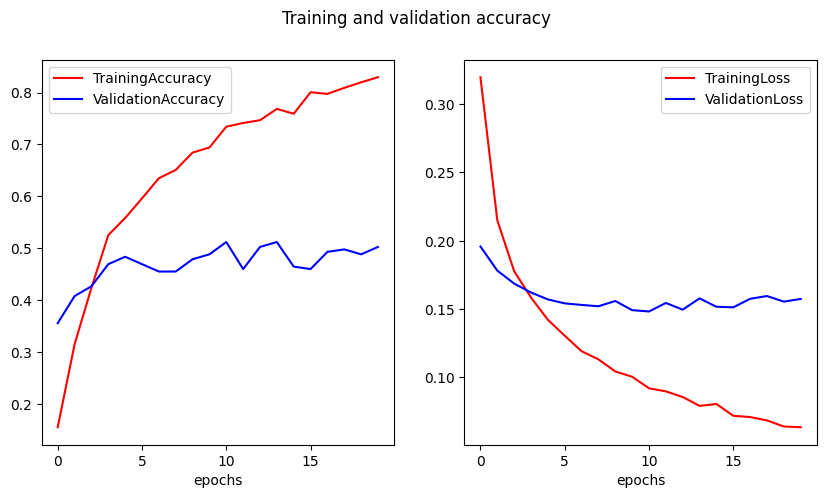

Training EfficientNetB0...
Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 45s 680ms/step - accuracy: 0.0835 - loss: 0.5171 - val_accuracy: 0.1232 - val_loss: 0.2359
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.1103 - loss: 0.2593 - val_accuracy: 0.1232 - val_loss: 0.2275
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.1011 - loss: 0.2534 - val_accuracy: 0.1232 - val_loss: 0.2275
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.1425 - loss: 0.2448 - val_accuracy: 0.1232 - val_loss: 0.2272
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.1137 - loss: 0.2459 - val_accuracy: 0.1232 - val_loss: 0.2271
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.1130 - loss: 0.2418 - val_accuracy: 0.1232 - val_loss: 0.2269
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.1315 - loss: 0.2413 - val_accuracy: 0.1232 - val_loss: 0.2267
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.1229 - loss: 

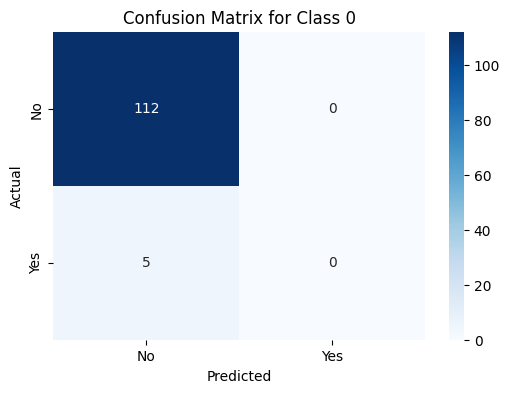

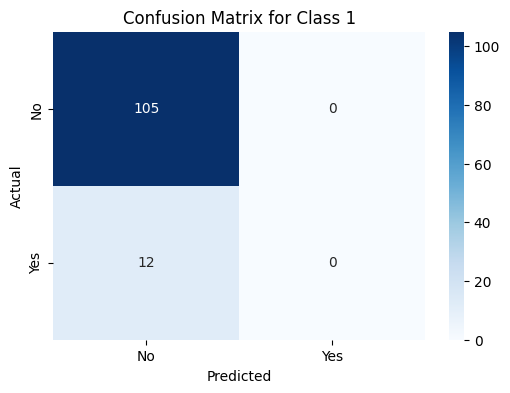

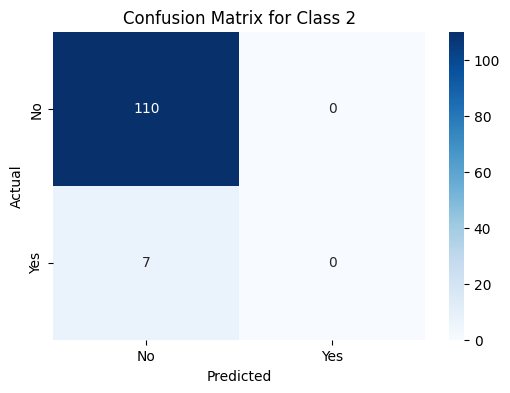

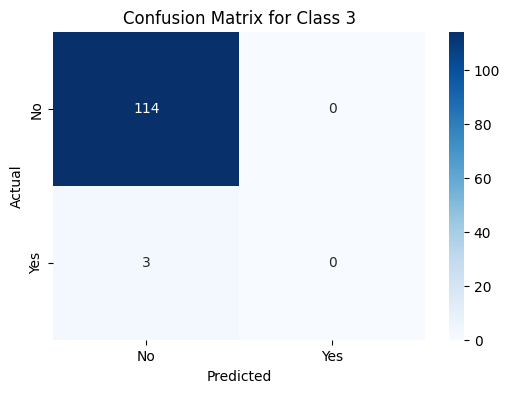

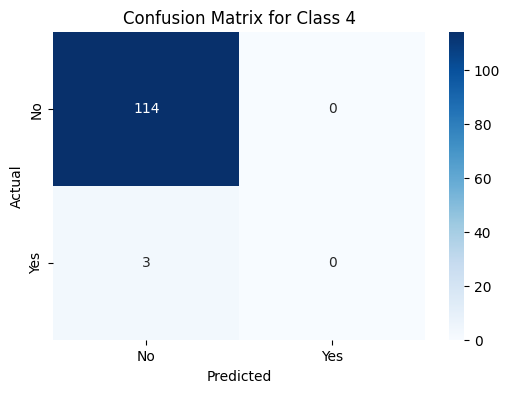

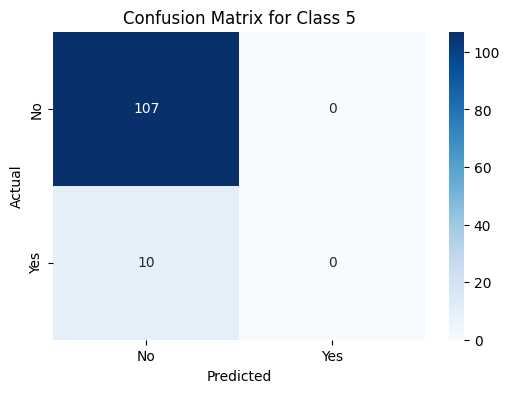

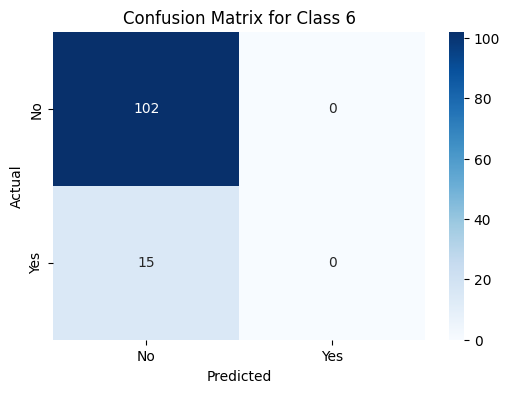

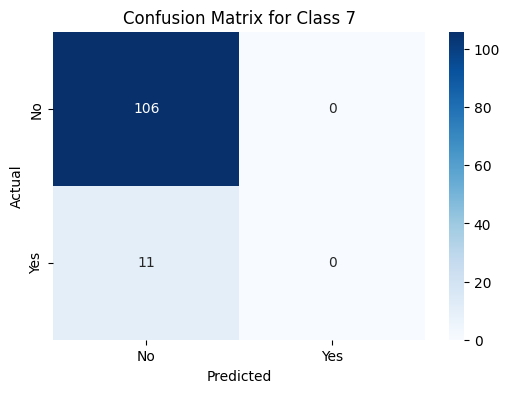

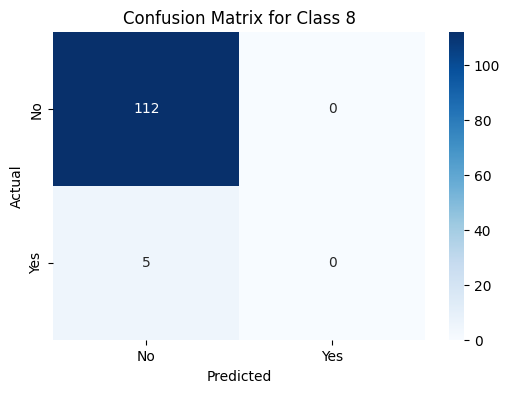

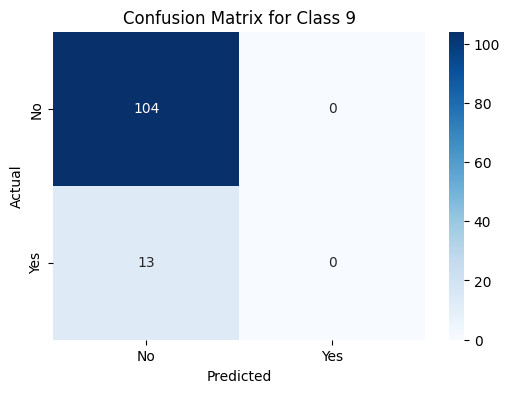

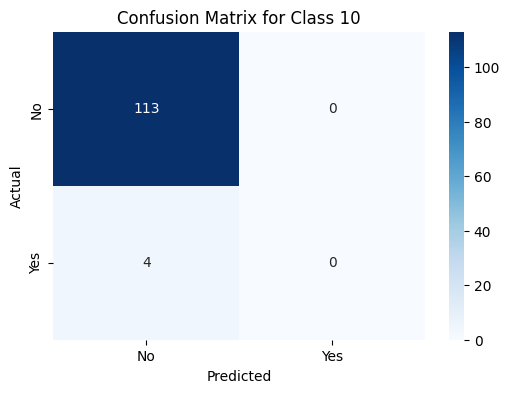

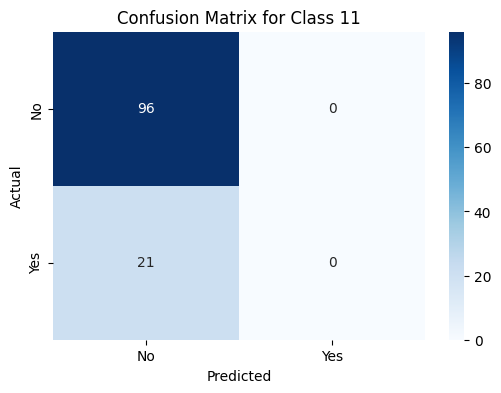

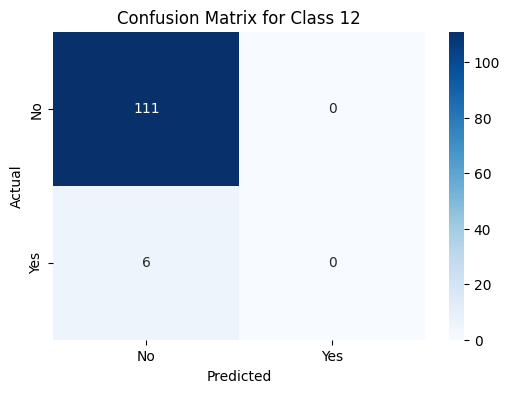

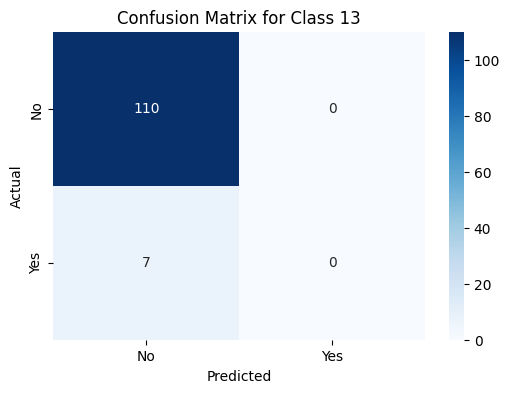

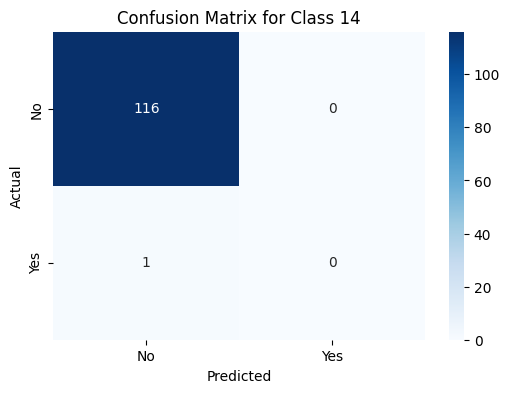

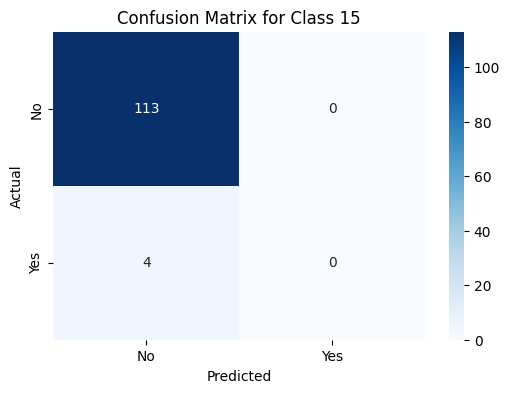

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for EfficientNetB0:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        15
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        13
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00        21
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         4

   micro avg       0.00      0.00    

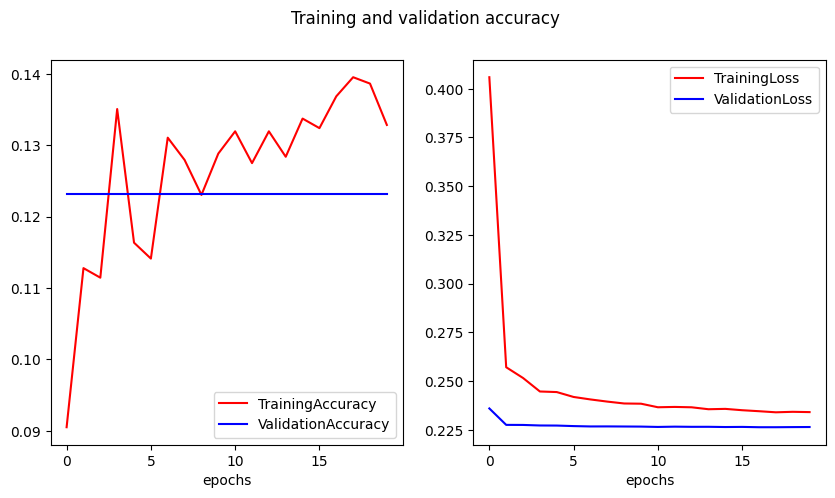

Training InceptionV3...
Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 45s 641ms/step - accuracy: 0.1177 - loss: 0.4024 - val_accuracy: 0.2749 - val_loss: 0.2057
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.2338 - loss: 0.2376 - val_accuracy: 0.3081 - val_loss: 0.1908
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.3263 - loss: 0.2117 - val_accuracy: 0.3555 - val_loss: 0.1799
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.3782 - loss: 0.1874 - val_accuracy: 0.3934 - val_loss: 0.1772
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.4188 - loss: 0.1784 - val_accuracy: 0.4645 - val_loss: 0.1700
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.4826 - loss: 0.1584 - val_accuracy: 0.4408 - val_loss: 0.1684
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.4559 - loss: 0.1631 - val_accuracy: 0.4692 - val_loss: 0.1668
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.5191 - loss: 

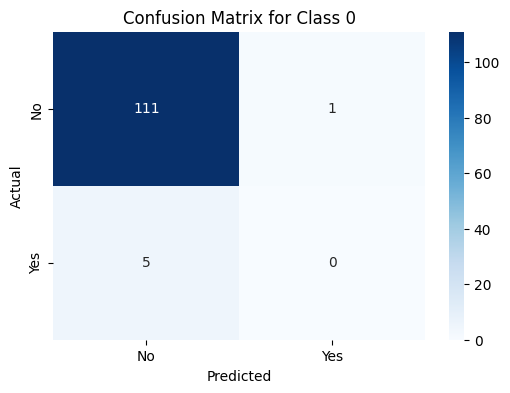

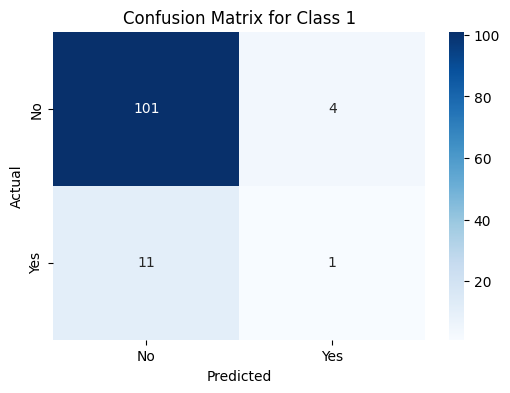

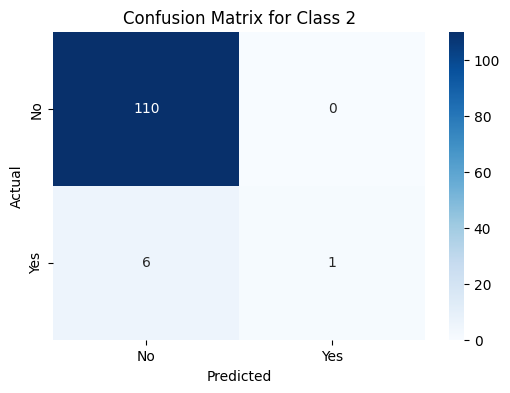

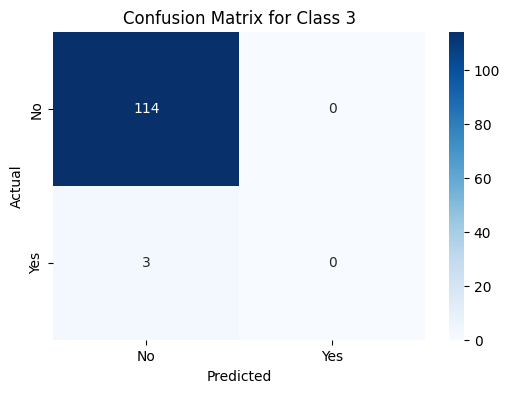

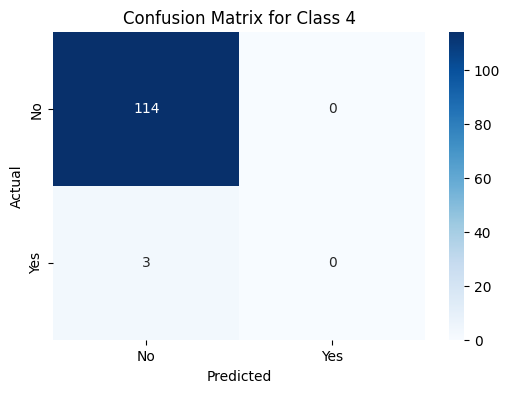

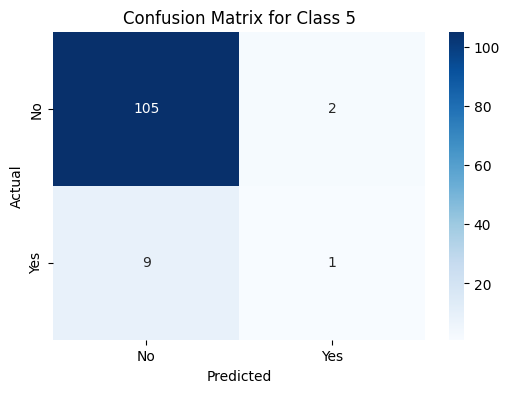

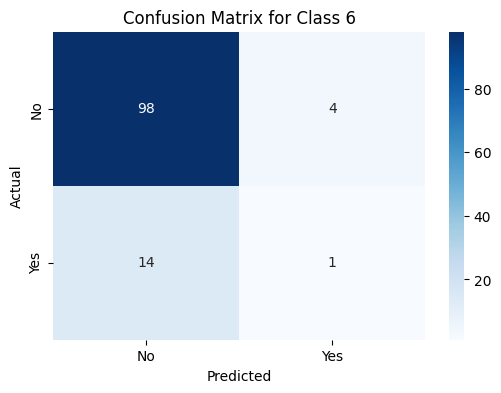

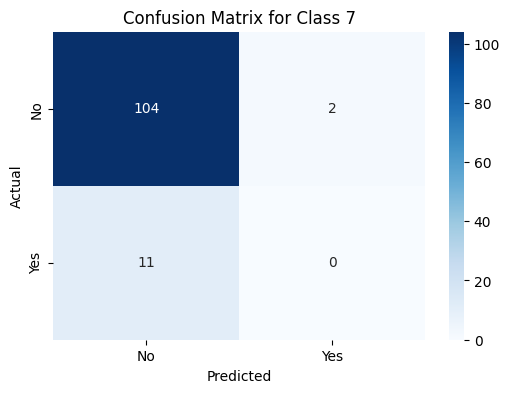

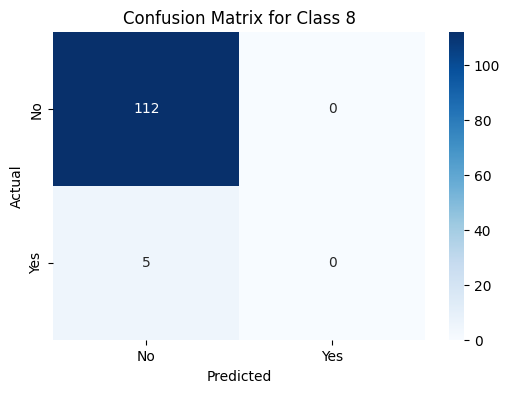

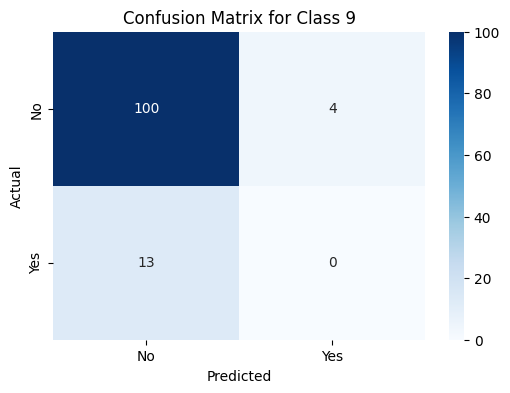

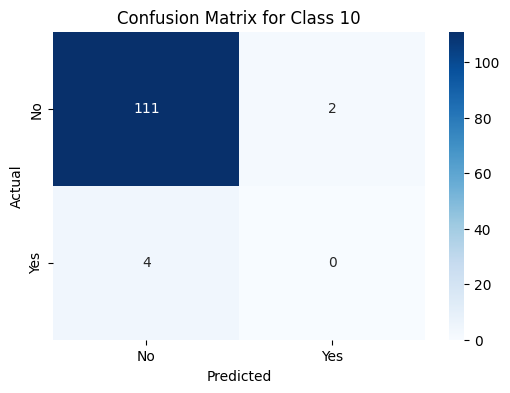

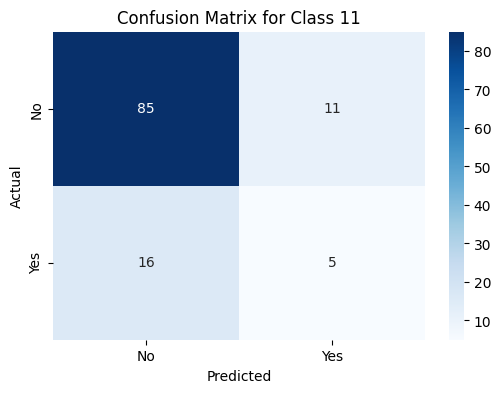

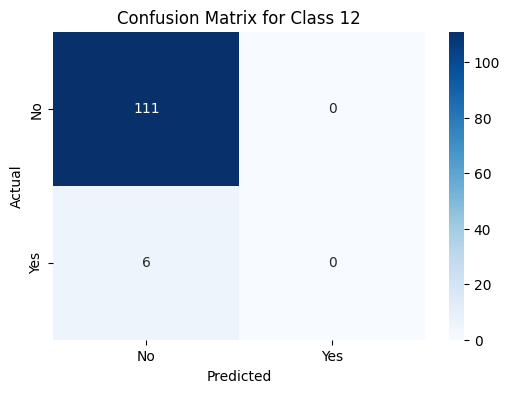

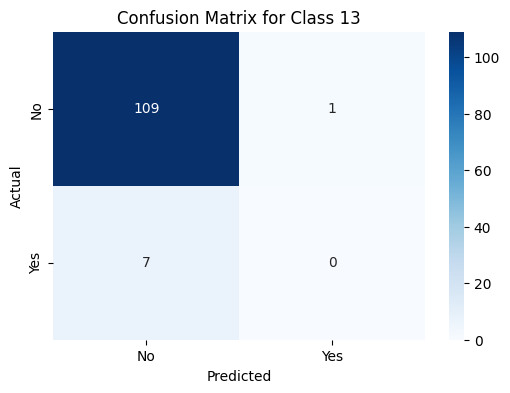

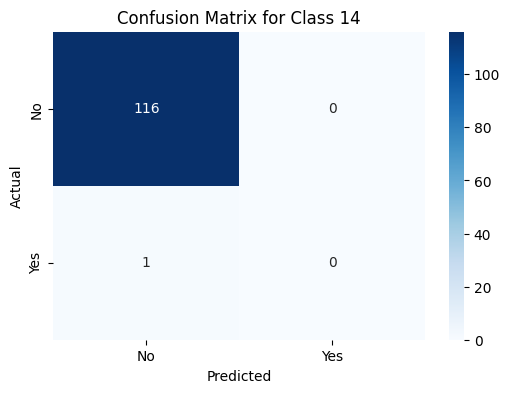

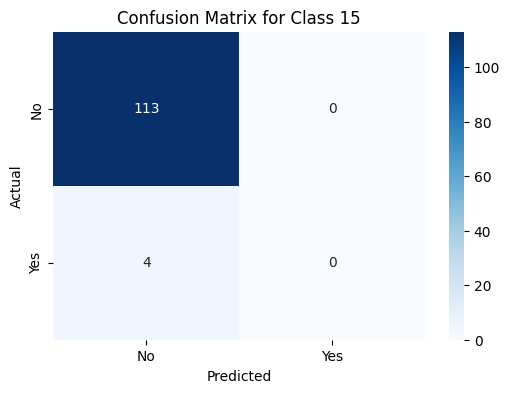

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for InceptionV3:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.20      0.08      0.12        12
           2       1.00      0.14      0.25         7
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.33      0.10      0.15        10
           6       0.20      0.07      0.10        15
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        13
          10       0.00      0.00      0.00         4
          11       0.31      0.24      0.27        21
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         4

   micro avg       0.23      0.07      0

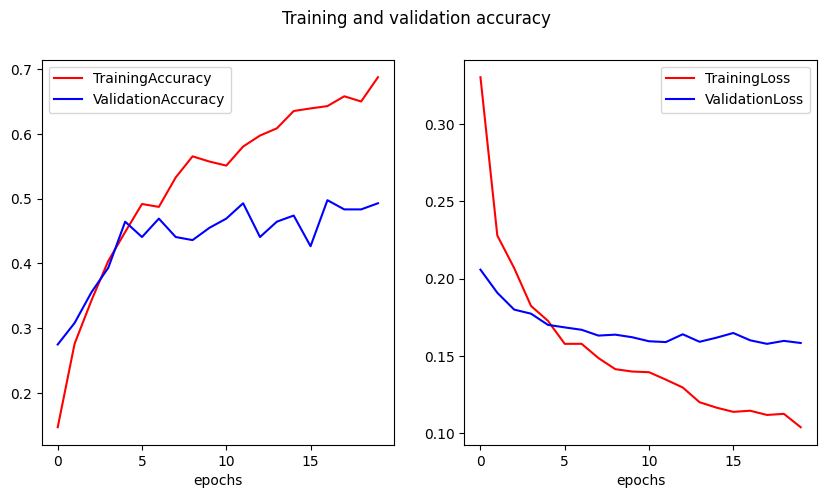

In [36]:
training(models, train_dataset, val_dataset, test_dataset)

# 7. FineTuning Model with Data Augmentation


In [53]:
# Load pretrained models
models_ft = {
    'ResNet50_ft': build_model(ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)), fine_tune=True),
    'MobileNetV2_ft': build_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)), fine_tune=True),
    'EfficientNetB0_ft': build_model(EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)), fine_tune=True),
    'InceptionV3_ft': build_model(InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)), fine_tune=True)
}

## 7.1 Load data with augmentation

In [52]:
# Load datasets
train_dataset_ft = create_dataset("/kaggle/input/leaf-disease-dataset/train", data_augment=True)
val_dataset_ft = create_dataset("/kaggle/input/leaf-disease-dataset/valid", data_augment=True)
test_dataset_ft = create_dataset("/kaggle/input/leaf-disease-dataset/test", data_augment=True)

## 7.2 Finetune

Training ResNet50_ft...
Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.1595 - loss: 0.3745 - val_accuracy: 0.1422 - val_loss: 9.2376
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 39s 915ms/step - accuracy: 0.3225 - loss: 0.2193 - val_accuracy: 0.1327 - val_loss: 1.1456
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 860ms/step - accuracy: 0.4309 - loss: 0.1933 - val_accuracy: 0.1327 - val_loss: 2.5323
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 876ms/step - accuracy: 0.4497 - loss: 0.1835 - val_accuracy: 0.0379 - val_loss: 0.4853
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 878ms/step - accuracy: 0.5194 - loss: 0.1568 - val_accuracy: 0.1327 - val_loss: 4.6170
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 883ms/step - accuracy: 0.5582 - loss: 0.1471 - val_accuracy: 0.1327 - val_loss: 0.7288
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 876ms/step - accuracy: 0.5559 - loss: 0.1475 - val_accuracy: 0.0190 - val_loss: 0.3663
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 875ms/step - accuracy: 0.6125 - l

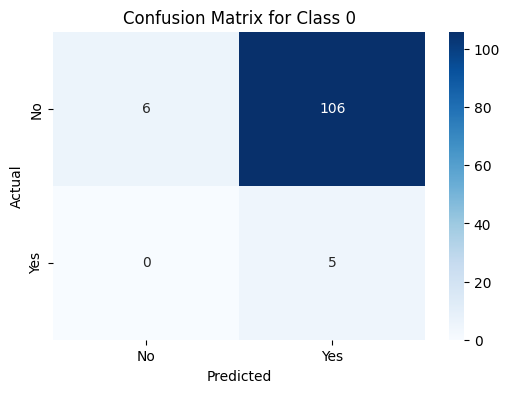

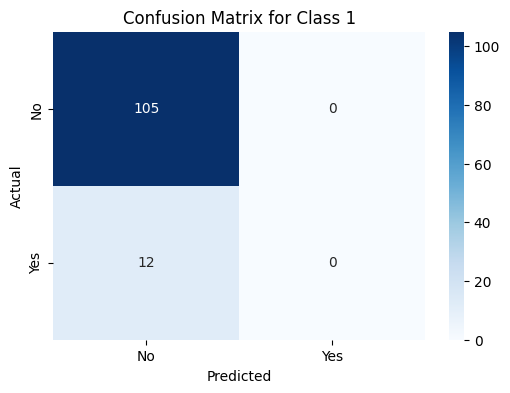

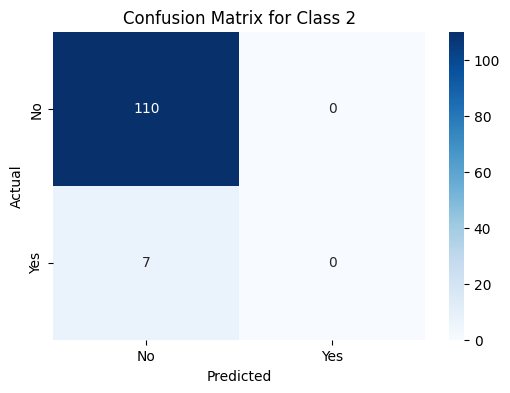

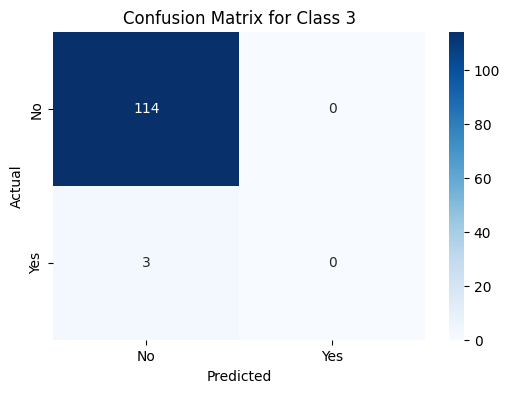

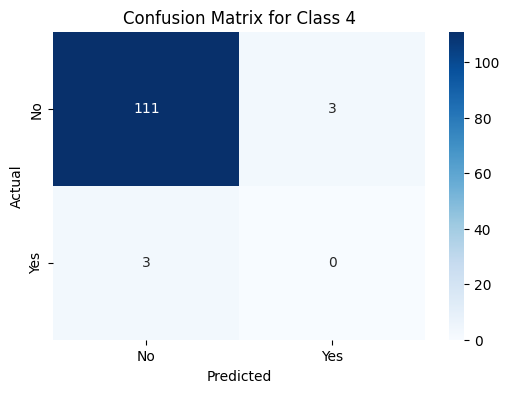

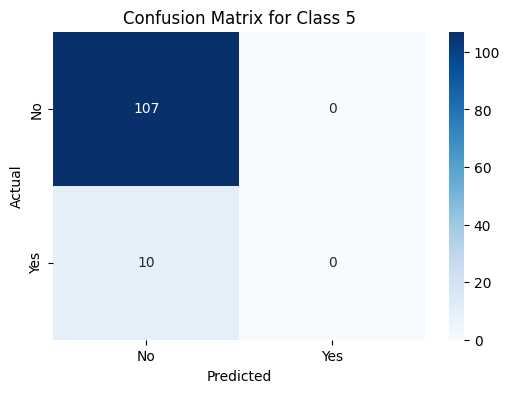

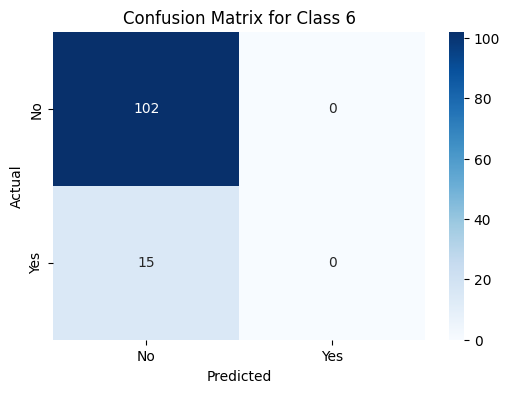

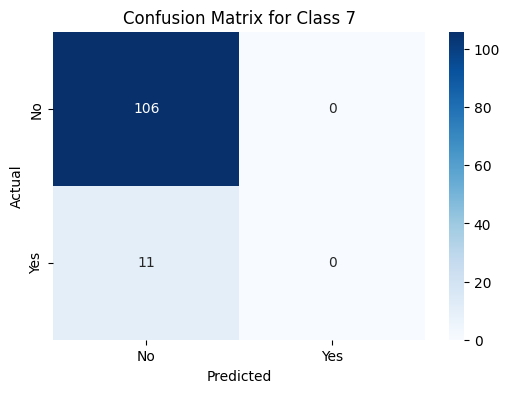

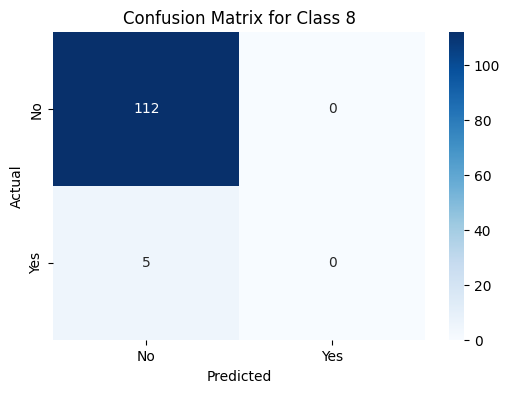

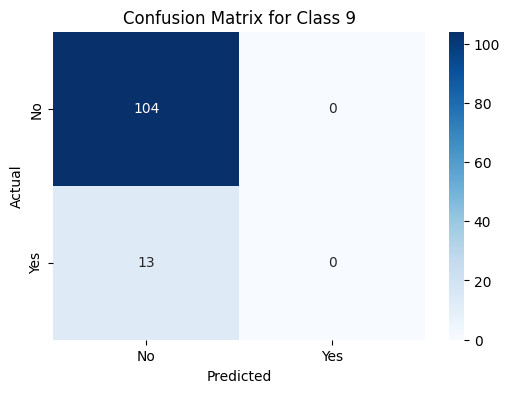

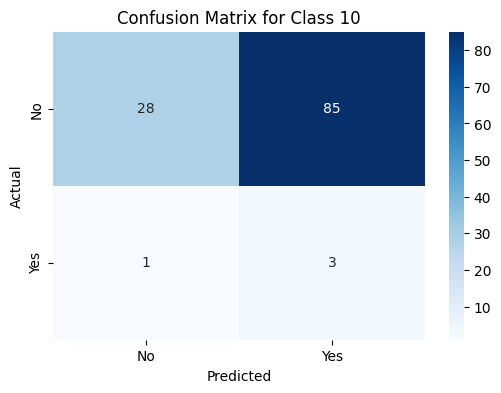

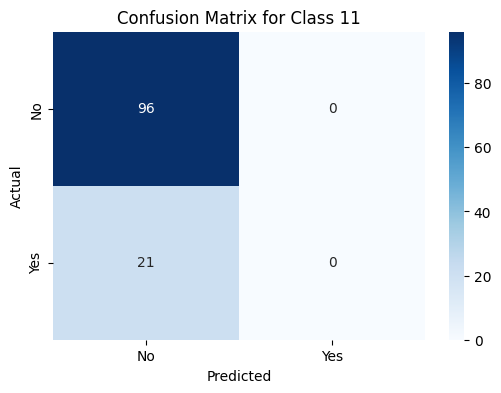

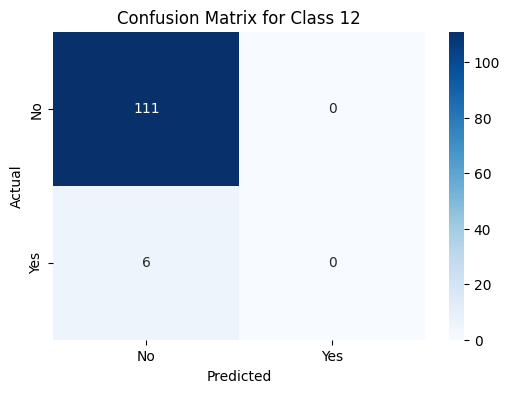

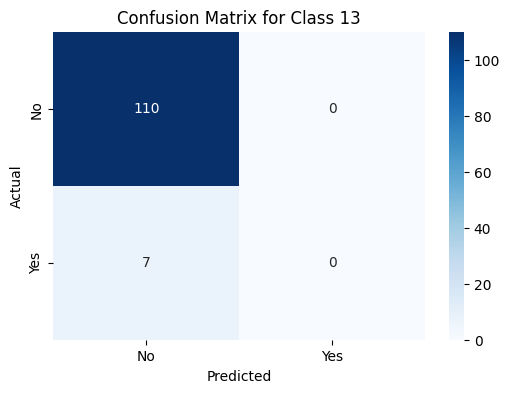

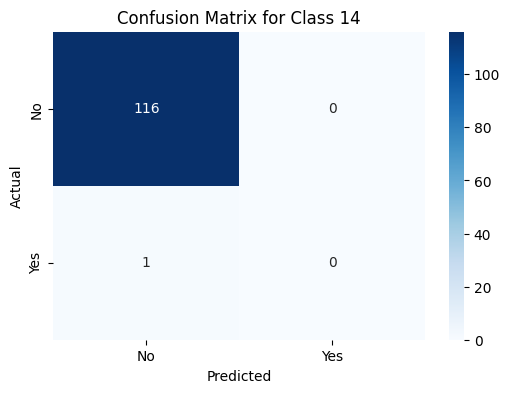

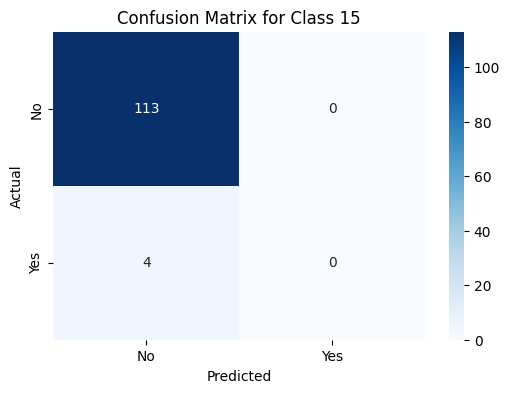

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for ResNet50_ft:
               precision    recall  f1-score   support

           0       0.05      1.00      0.09         5
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        15
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        13
          10       0.03      0.75      0.07         4
          11       0.00      0.00      0.00        21
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         4

   micro avg       0.04      0.06      0

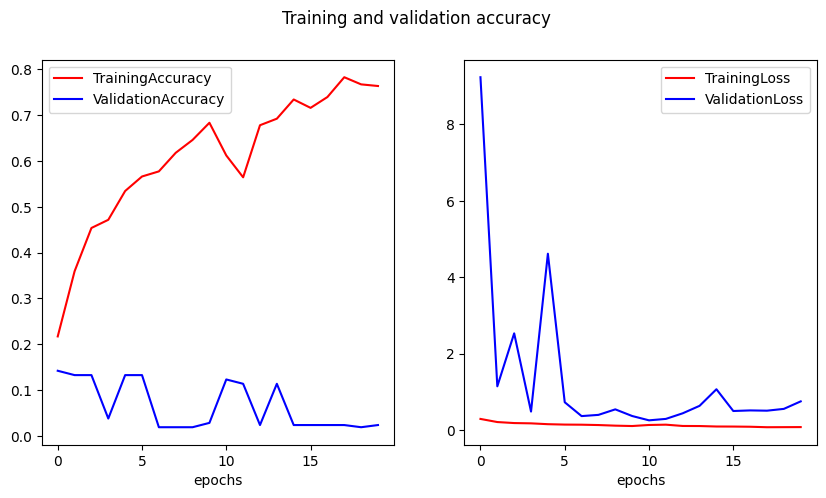

Training MobileNetV2_ft...
Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.1335 - loss: 0.4017 - val_accuracy: 0.1232 - val_loss: 1.9647
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 452ms/step - accuracy: 0.4474 - loss: 0.1875 - val_accuracy: 0.1043 - val_loss: 1.5999
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 454ms/step - accuracy: 0.5644 - loss: 0.1441 - val_accuracy: 0.1374 - val_loss: 1.1439
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 444ms/step - accuracy: 0.6228 - loss: 0.1285 - val_accuracy: 0.1043 - val_loss: 1.3575
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 442ms/step - accuracy: 0.6999 - loss: 0.1071 - val_accuracy: 0.0995 - val_loss: 0.9477
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - accuracy: 0.6782 - loss: 0.1120 - val_accuracy: 0.0427 - val_loss: 1.1128
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 446ms/step - accuracy: 0.7353 - loss: 0.0962 - val_accuracy: 0.0237 - val_loss: 0.9995
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 447ms/step - accuracy: 0.7556 -

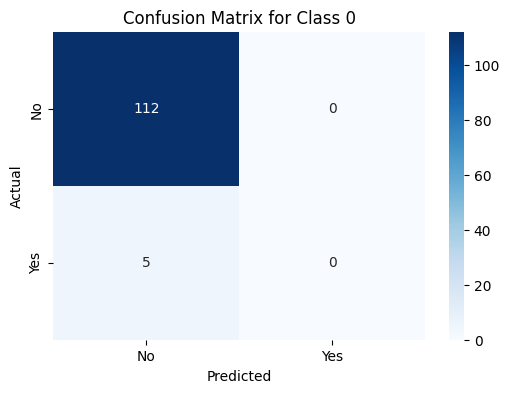

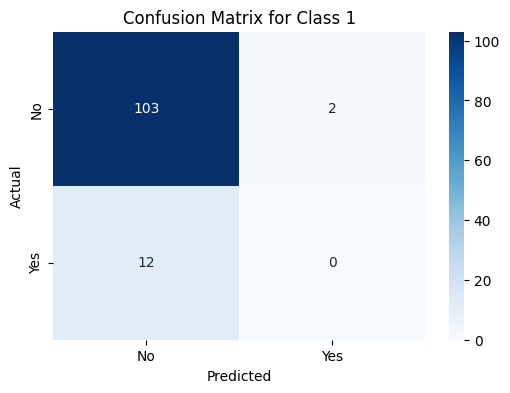

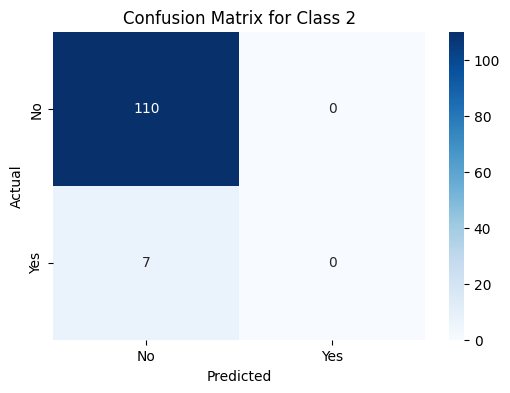

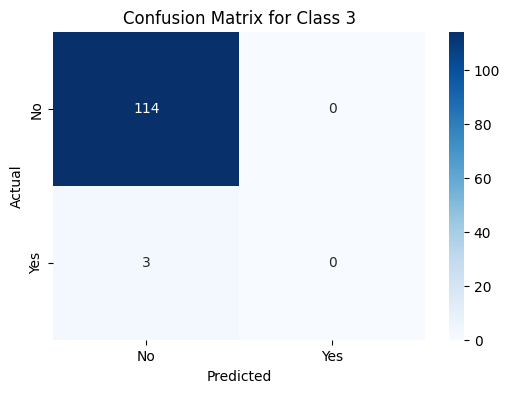

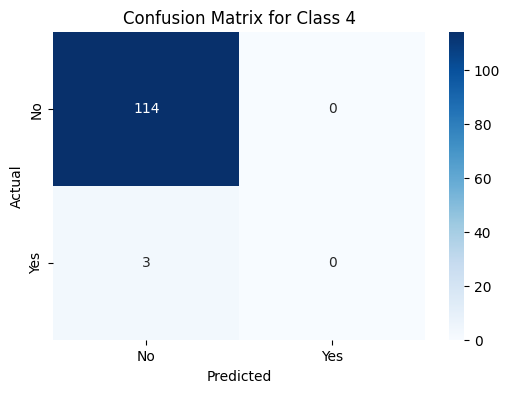

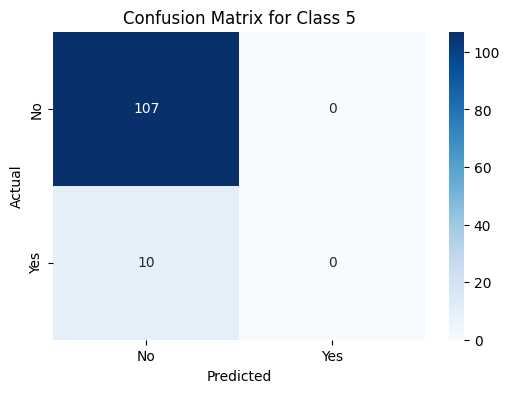

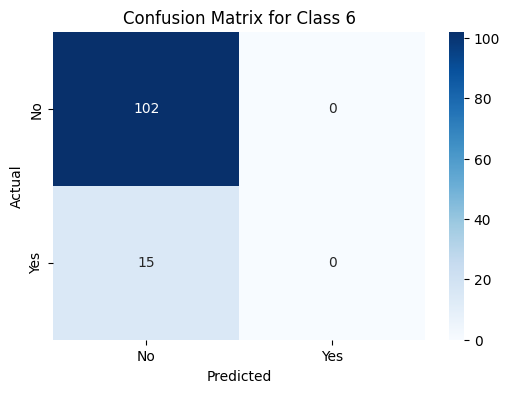

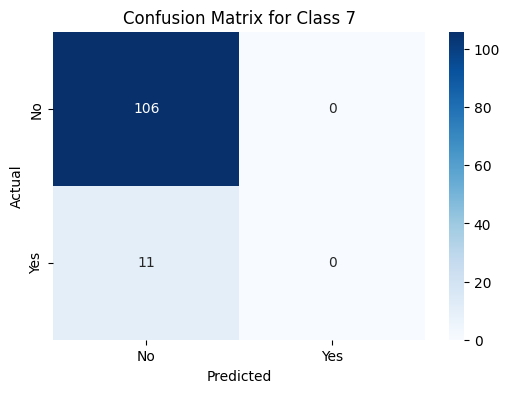

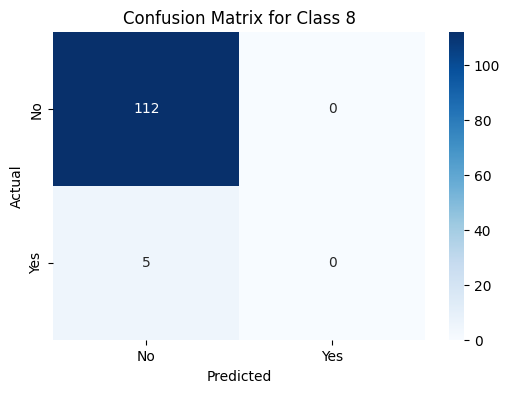

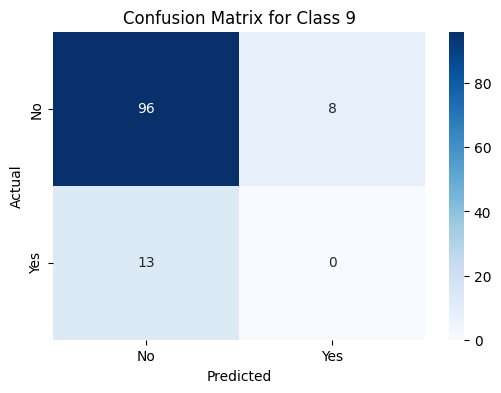

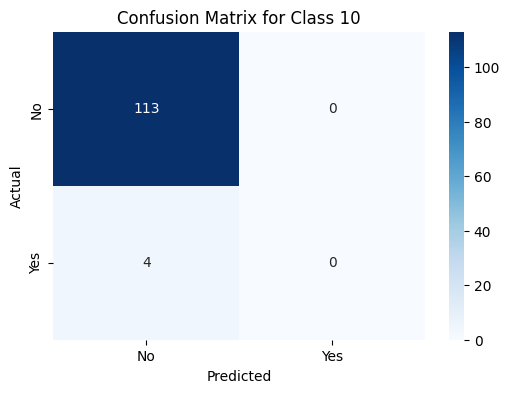

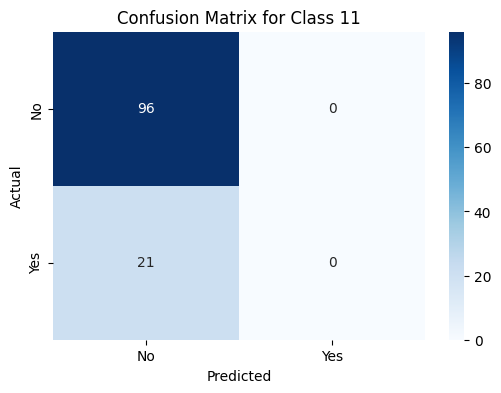

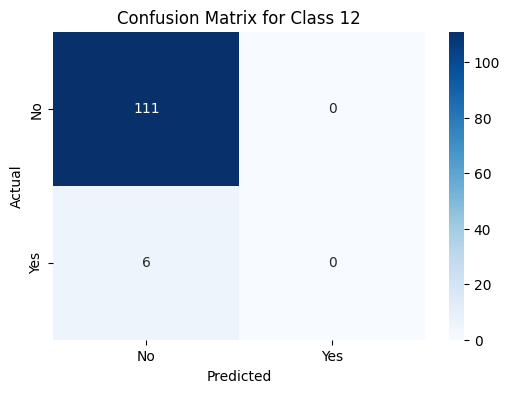

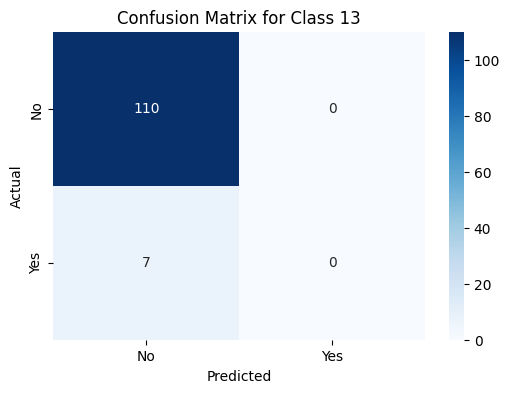

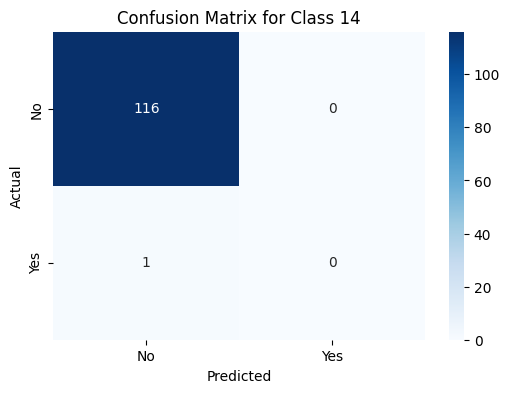

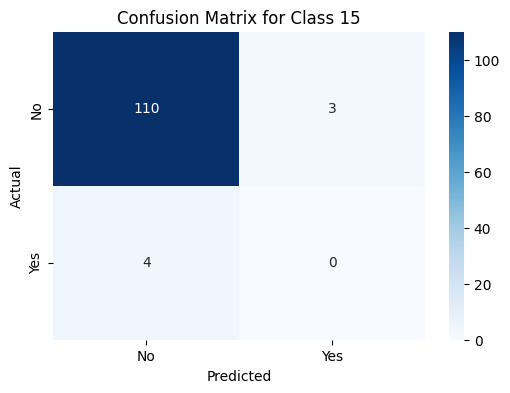

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for MobileNetV2_ft:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        15
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        13
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00        21
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         4

   micro avg       0.00      0.00    

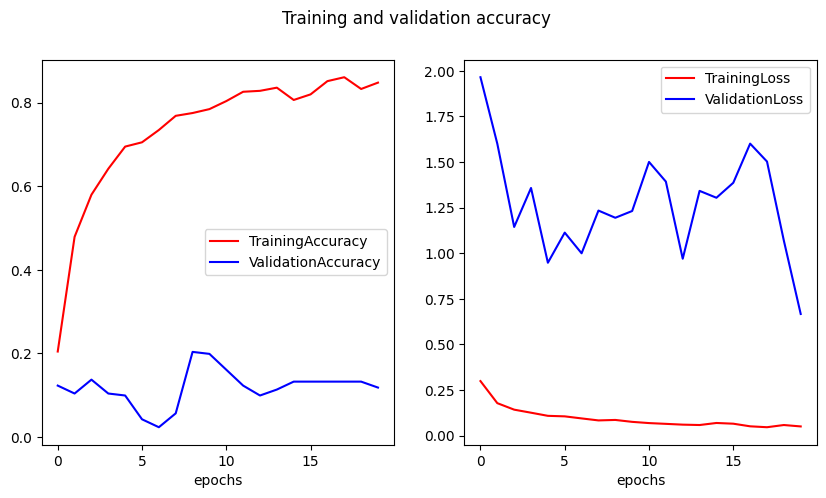

Training EfficientNetB0_ft...
Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.1105 - loss: 0.4029 - val_accuracy: 0.0474 - val_loss: 0.5164
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 516ms/step - accuracy: 0.4178 - loss: 0.1886 - val_accuracy: 0.0237 - val_loss: 0.3029
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 532ms/step - accuracy: 0.6202 - loss: 0.1256 - val_accuracy: 0.0237 - val_loss: 0.3800
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 510ms/step - accuracy: 0.7477 - loss: 0.0886 - val_accuracy: 0.0190 - val_loss: 0.8190
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 503ms/step - accuracy: 0.8089 - loss: 0.0708 - val_accuracy: 0.0190 - val_loss: 0.8480
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 524ms/step - accuracy: 0.8110 - loss: 0.0658 - val_accuracy: 0.0332 - val_loss: 0.8629
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 516ms/step - accuracy: 0.8288 - loss: 0.0603 - val_accuracy: 0.0995 - val_loss: 0.4237
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 510ms/step - accuracy: 0.87

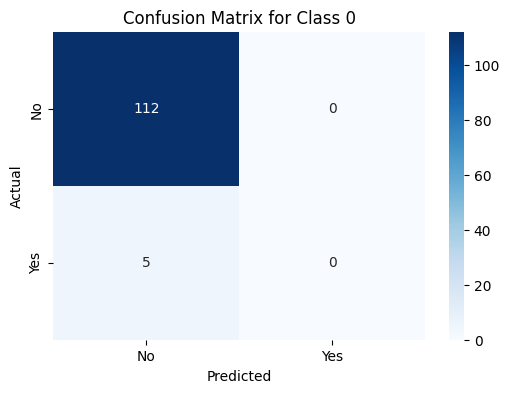

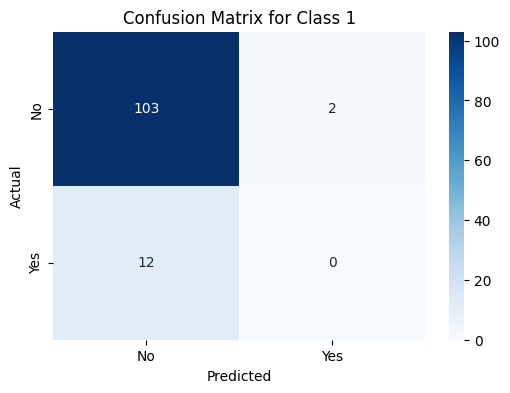

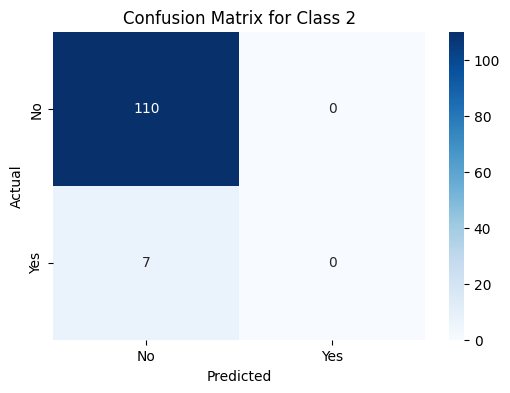

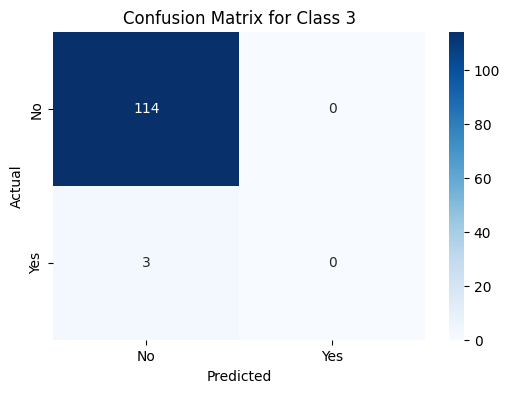

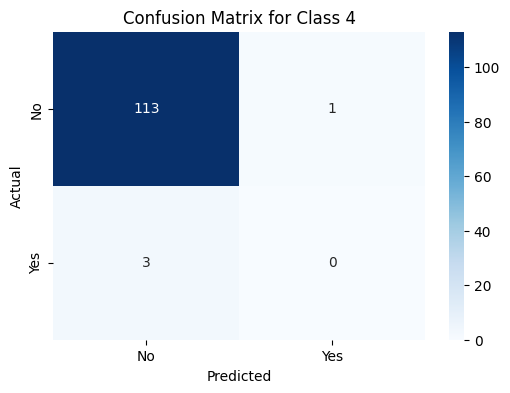

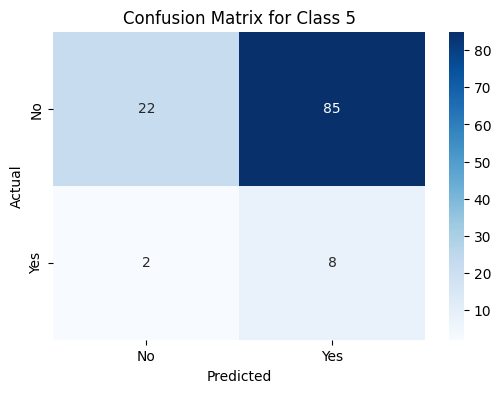

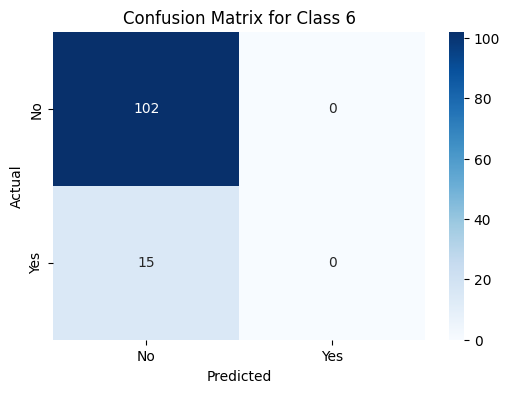

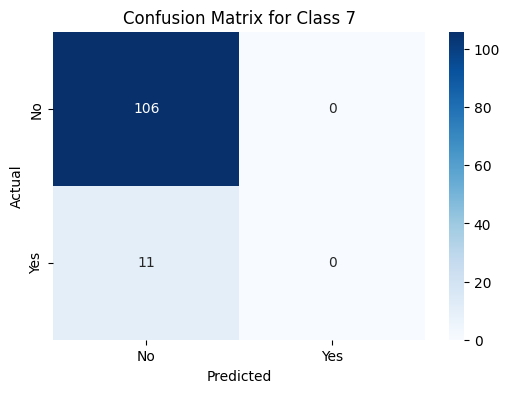

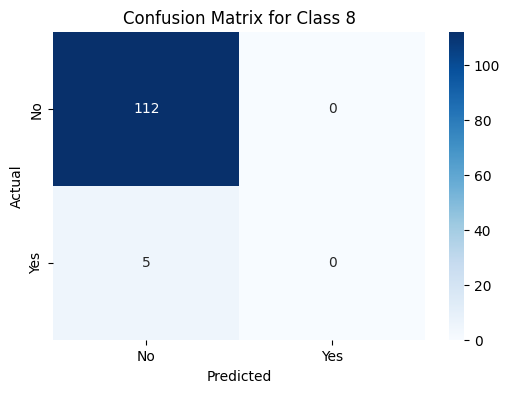

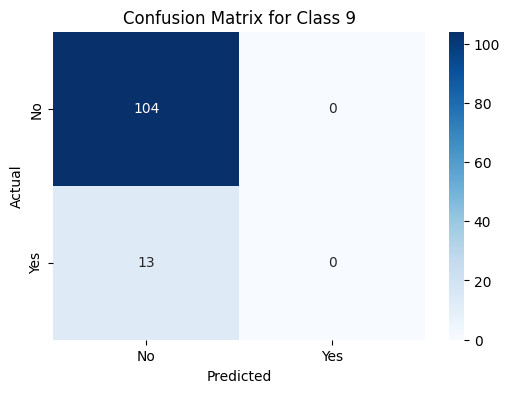

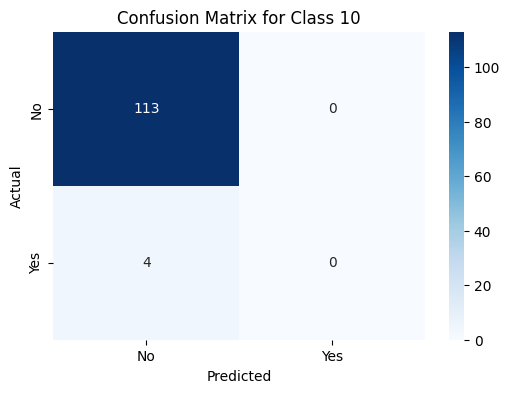

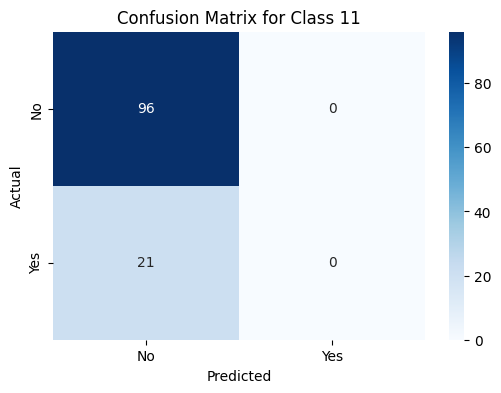

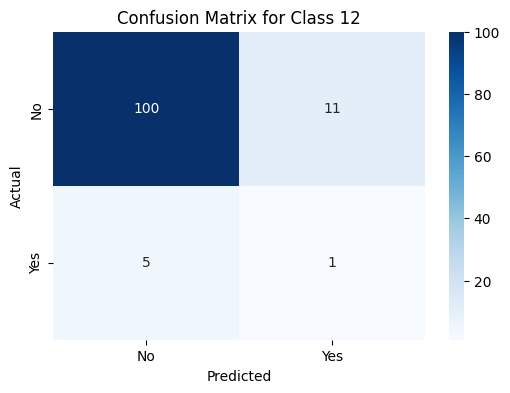

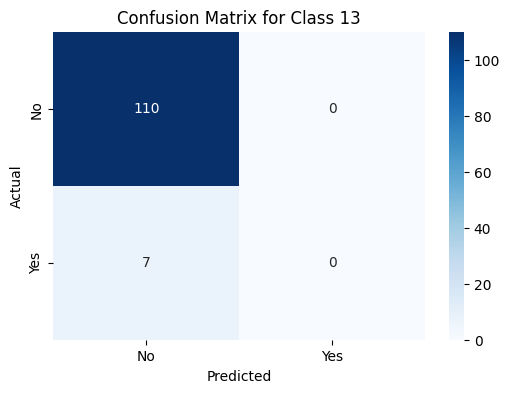

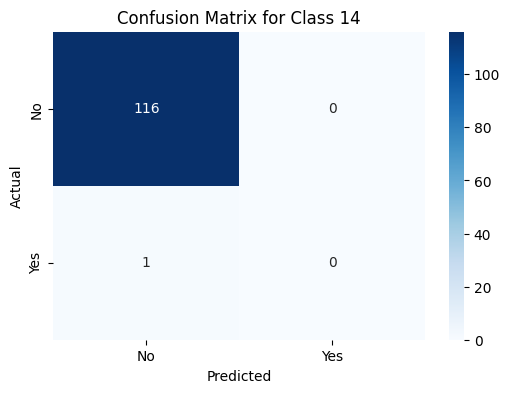

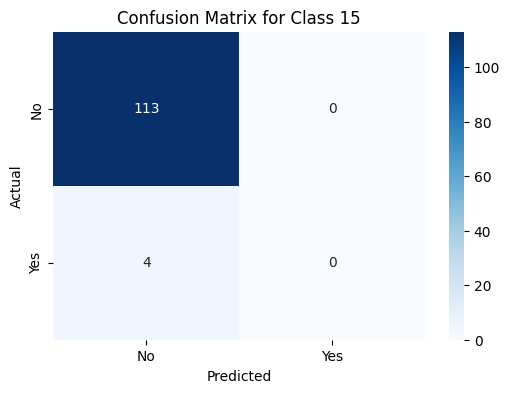

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for EfficientNetB0_ft:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.09      0.80      0.16        10
           6       0.00      0.00      0.00        15
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        13
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00        21
          12       0.08      0.17      0.11         6
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         4

   micro avg       0.08      0.07 

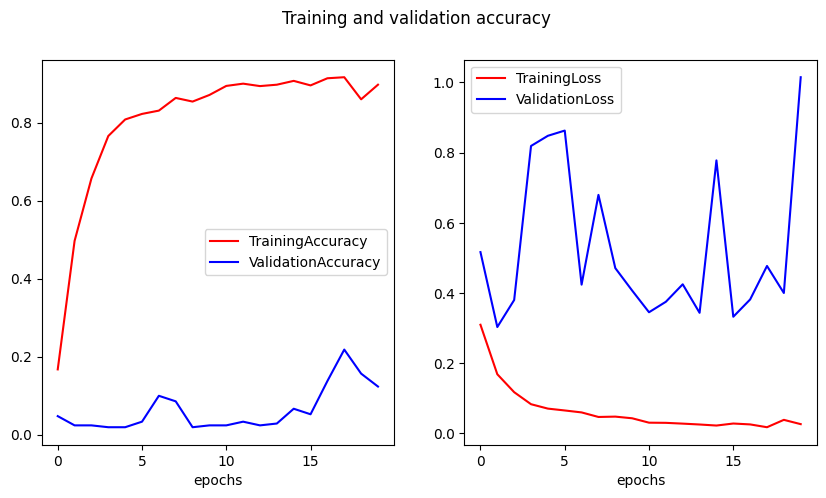

Training InceptionV3_ft...
Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.0941 - loss: 0.3796 - val_accuracy: 0.0237 - val_loss: 1825.7327
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 706ms/step - accuracy: 0.1480 - loss: 0.2596 - val_accuracy: 0.0190 - val_loss: 2862.4795
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 696ms/step - accuracy: 0.1905 - loss: 0.2445 - val_accuracy: 0.0190 - val_loss: 67.3380
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 699ms/step - accuracy: 0.1912 - loss: 0.2351 - val_accuracy: 0.1659 - val_loss: 0.5305
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 702ms/step - accuracy: 0.2442 - loss: 0.2330 - val_accuracy: 0.1327 - val_loss: 1.0798
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 702ms/step - accuracy: 0.2609 - loss: 0.2202 - val_accuracy: 0.1896 - val_loss: 0.2849
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 702ms/step - accuracy: 0.3406 - loss: 0.2035 - val_accuracy: 0.2512 - val_loss: 0.3543
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 704ms/step - accuracy: 

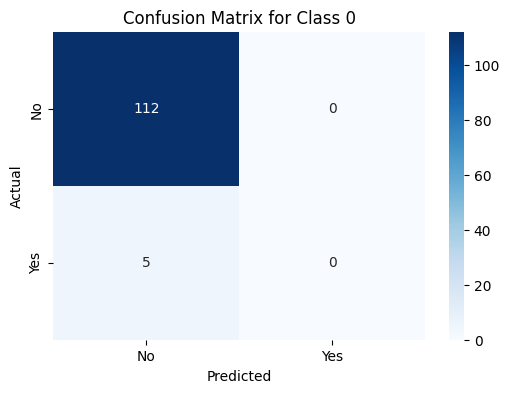

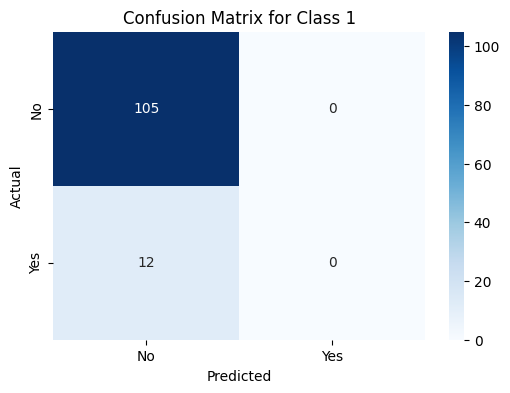

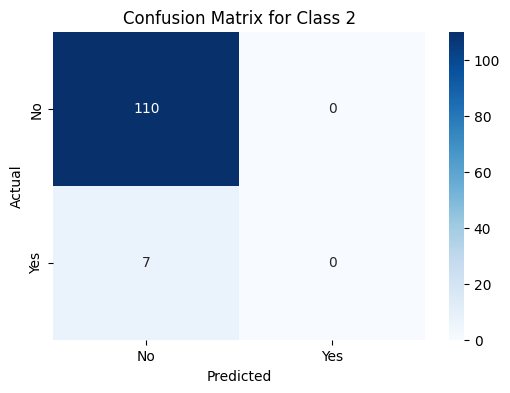

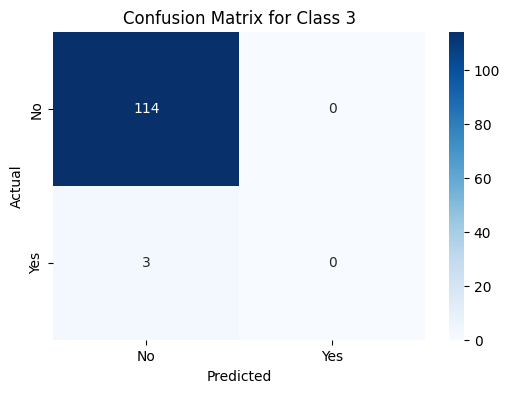

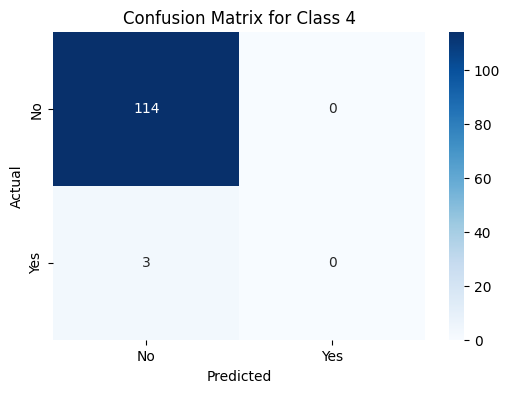

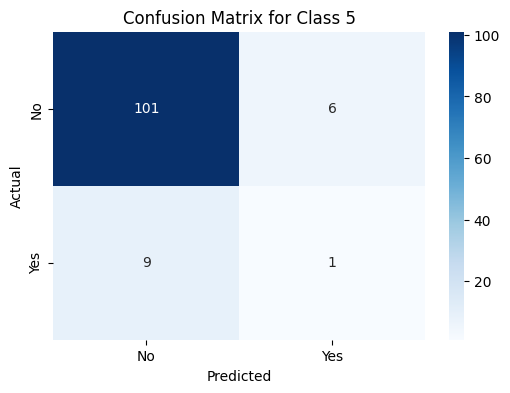

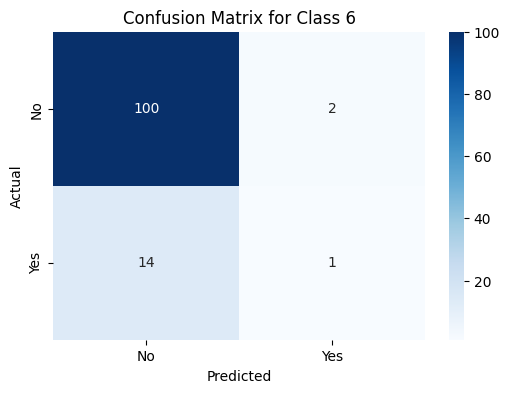

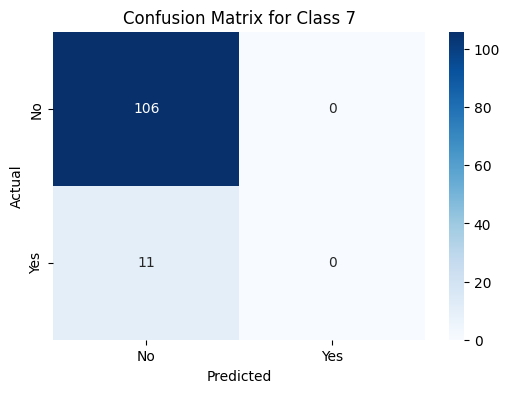

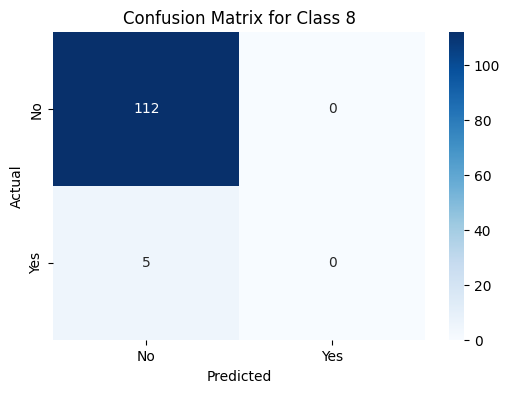

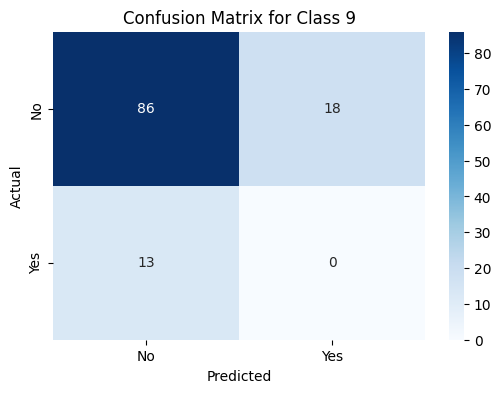

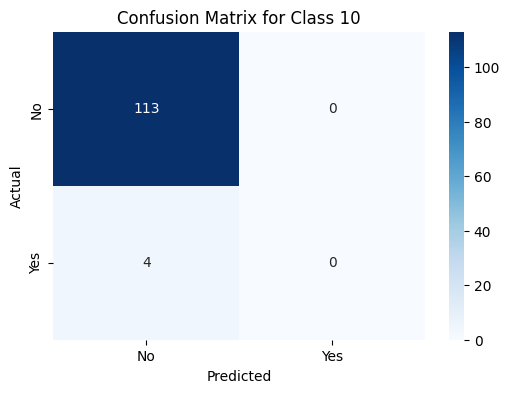

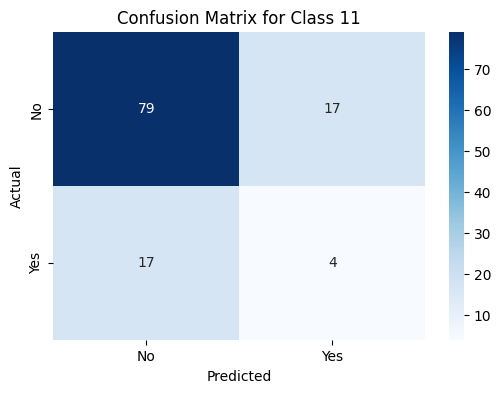

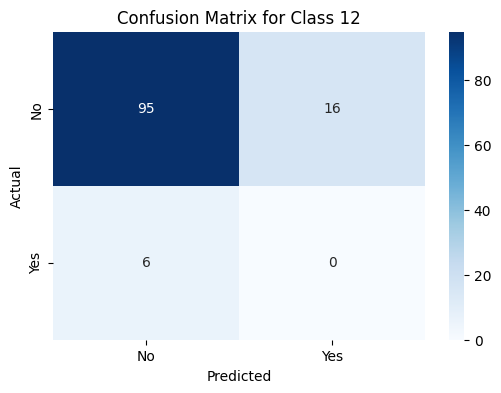

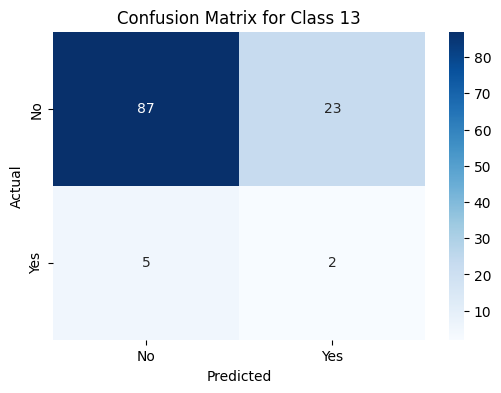

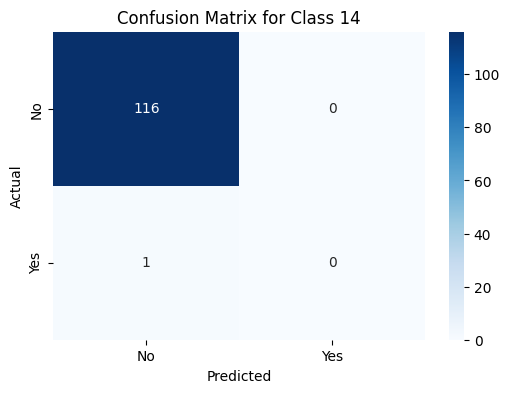

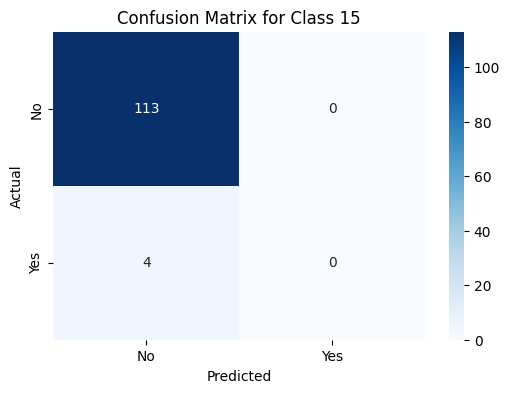

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for InceptionV3_ft:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.14      0.10      0.12        10
           6       0.33      0.07      0.11        15
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        13
          10       0.00      0.00      0.00         4
          11       0.19      0.19      0.19        21
          12       0.00      0.00      0.00         6
          13       0.08      0.29      0.12         7
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         4

   micro avg       0.09      0.06    

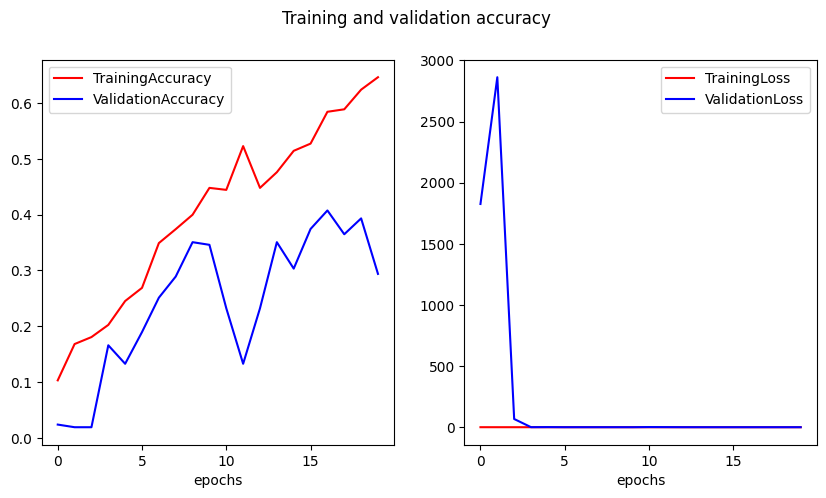

In [54]:
training(models_ft, train_dataset_ft, val_dataset_ft, test_dataset_ft)

# 8. Add L2 regularization to reduce overfit

In [61]:
# Load pretrained models
models_l2 = {
    'ResNet50_l2': build_model(ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)), fine_tune=True, regular=True),
    'MobileNetV2_l2': build_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)), fine_tune=True, regular=True),
    'EfficientNetB0_l2': build_model(EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)), fine_tune=True, regular=True),
    'InceptionV3_l2': build_model(InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)), fine_tune=True, regular=True)
}

Training ResNet50_l2...
Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.1437 - loss: 2.2932 - val_accuracy: 0.1422 - val_loss: 1.0244
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 893ms/step - accuracy: 0.2852 - loss: 0.6227 - val_accuracy: 0.1232 - val_loss: 0.4046
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 889ms/step - accuracy: 0.3995 - loss: 0.2716 - val_accuracy: 0.1232 - val_loss: 0.2774
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 869ms/step - accuracy: 0.4462 - loss: 0.2056 - val_accuracy: 0.0190 - val_loss: 0.3102
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 878ms/step - accuracy: 0.5023 - loss: 0.1810 - val_accuracy: 0.0237 - val_loss: 0.3972
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 874ms/step - accuracy: 0.5403 - loss: 0.1734 - val_accuracy: 0.1137 - val_loss: 0.5084
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 886ms/step - accuracy: 0.5238 - loss: 0.1717 - val_accuracy: 0.0190 - val_loss: 0.5622
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 872ms/step - accuracy: 0.5735 - l

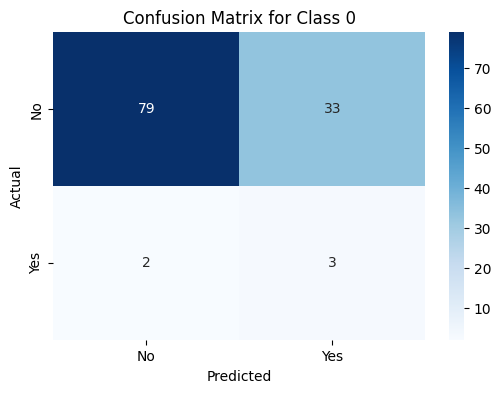

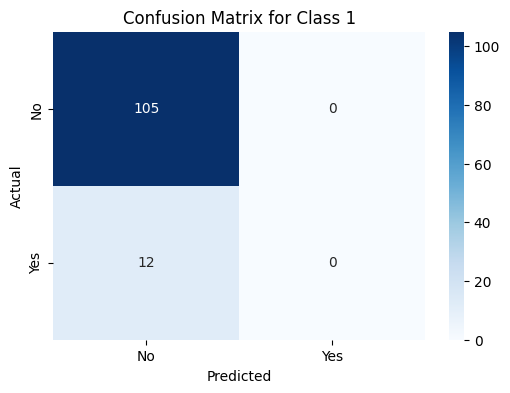

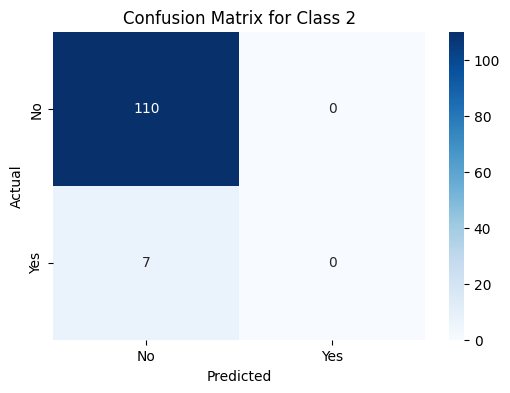

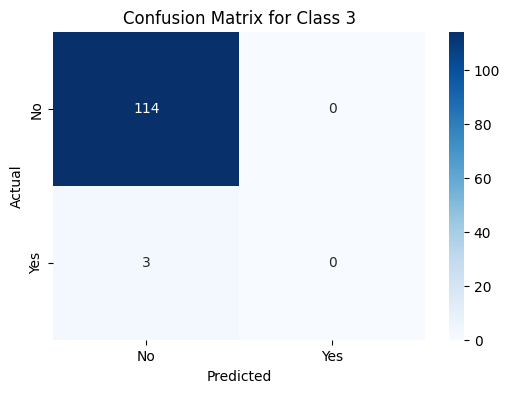

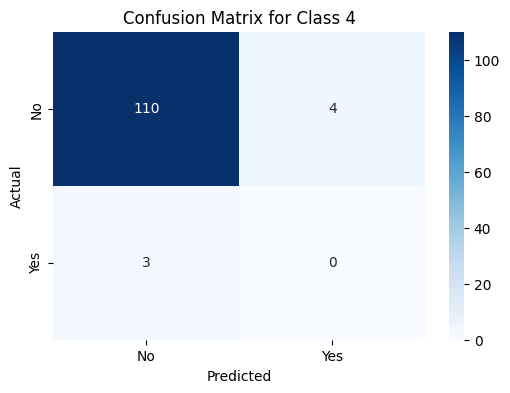

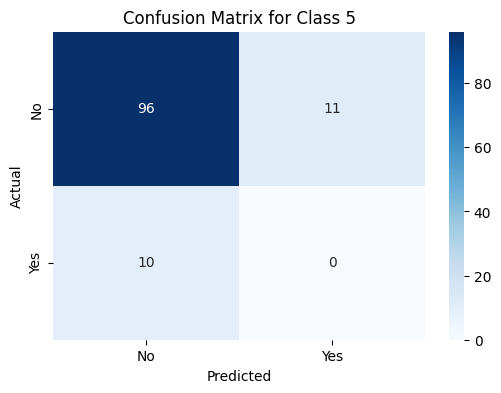

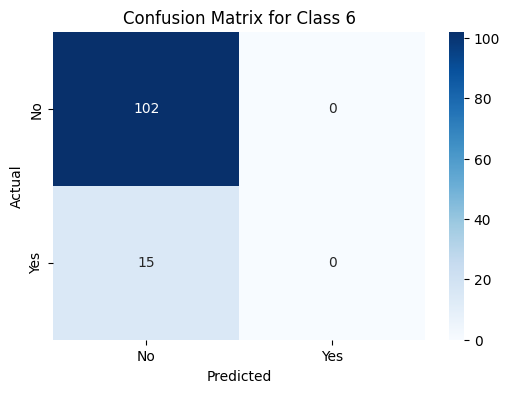

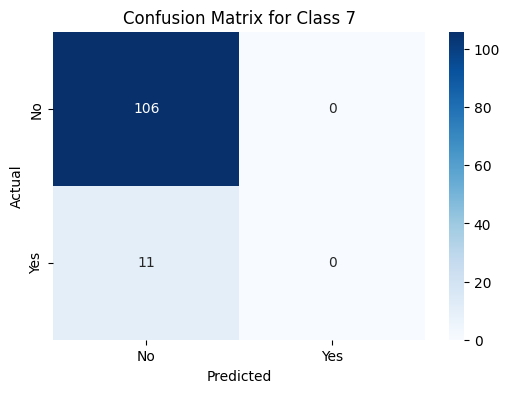

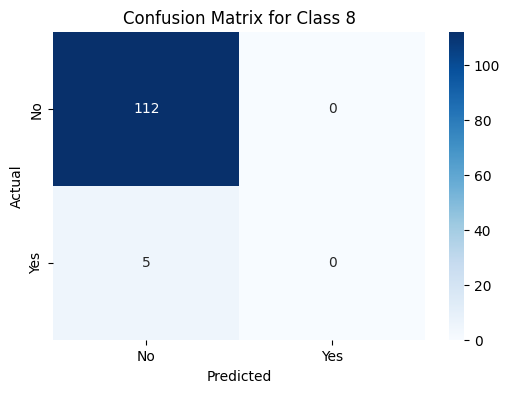

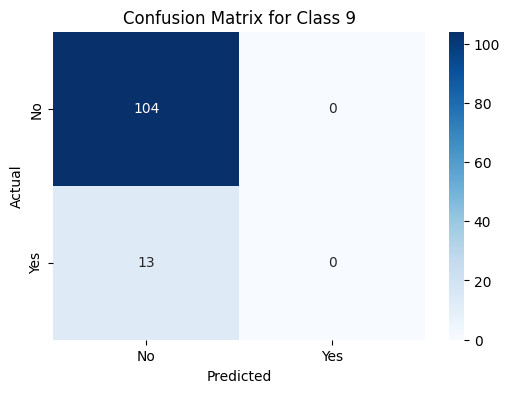

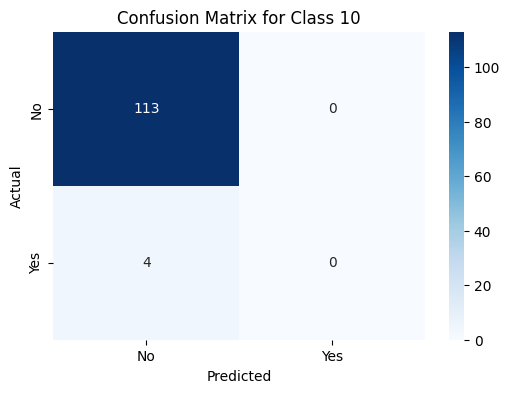

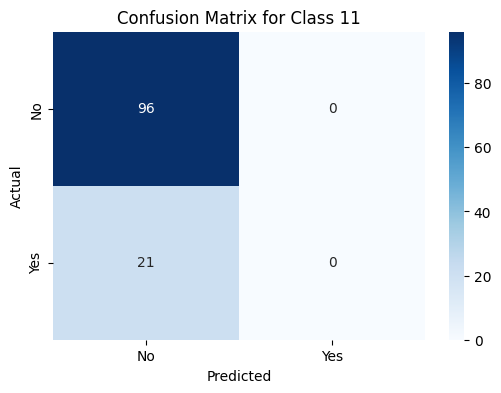

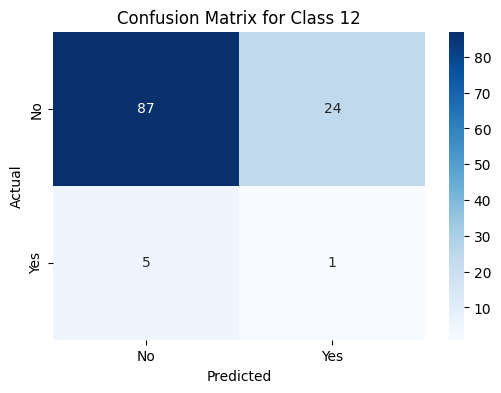

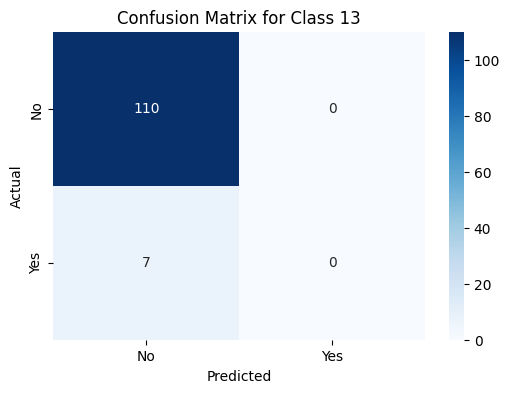

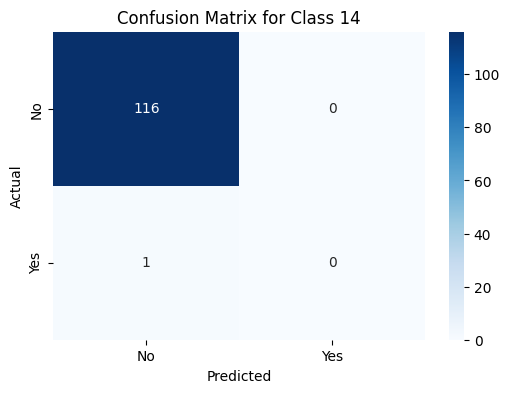

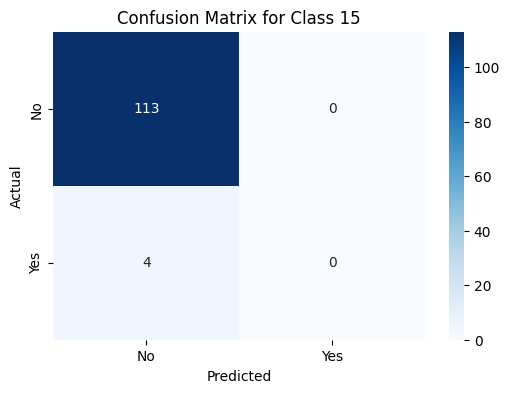

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for ResNet50_l2:
               precision    recall  f1-score   support

           0       0.08      0.60      0.15         5
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        15
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        13
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00        21
          12       0.04      0.17      0.06         6
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         4

   micro avg       0.05      0.03      0

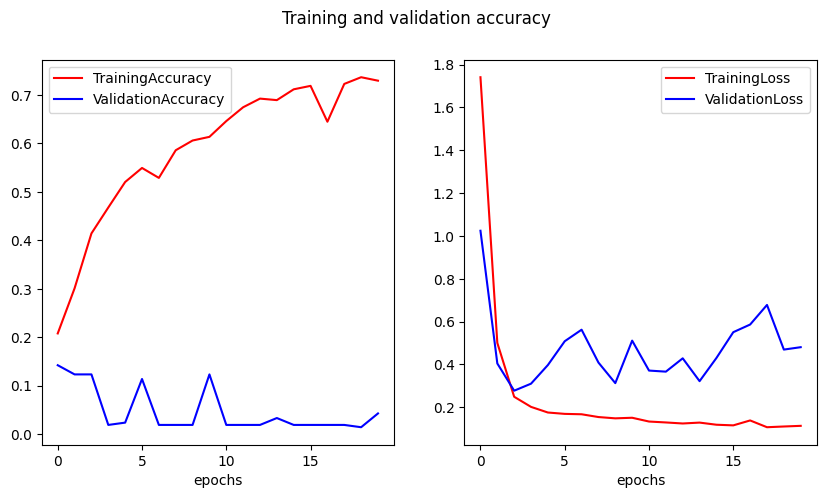

Training MobileNetV2_l2...
Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.1432 - loss: 2.2408 - val_accuracy: 0.2417 - val_loss: 1.1618
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 445ms/step - accuracy: 0.4390 - loss: 0.6237 - val_accuracy: 0.2275 - val_loss: 0.6949
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 448ms/step - accuracy: 0.5318 - loss: 0.2550 - val_accuracy: 0.1517 - val_loss: 0.5313
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - accuracy: 0.6509 - loss: 0.1636 - val_accuracy: 0.1137 - val_loss: 0.7509
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.6823 - loss: 0.1393 - val_accuracy: 0.0521 - val_loss: 0.7966
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 451ms/step - accuracy: 0.7502 - loss: 0.1219 - val_accuracy: 0.1280 - val_loss: 0.7563
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 446ms/step - accuracy: 0.7417 - loss: 0.1172 - val_accuracy: 0.1754 - val_loss: 0.6991
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 451ms/step - accuracy: 0.7942 -

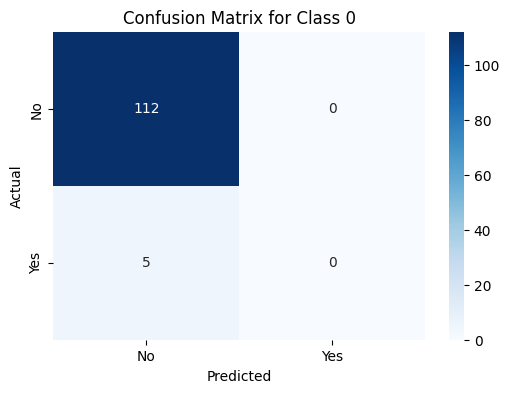

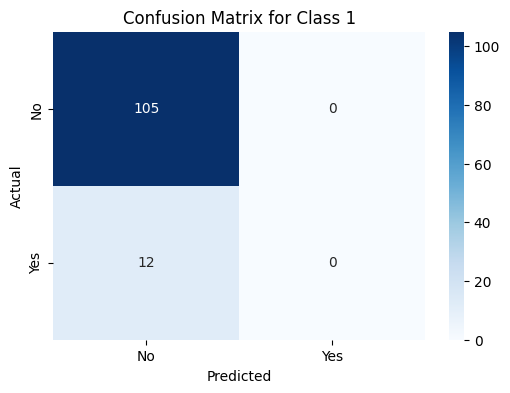

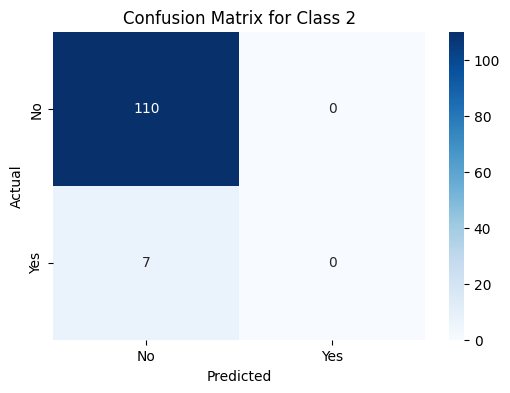

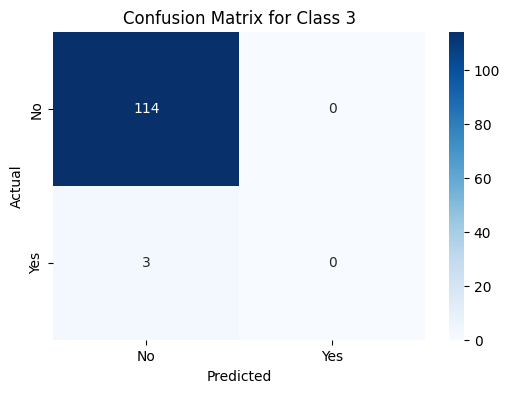

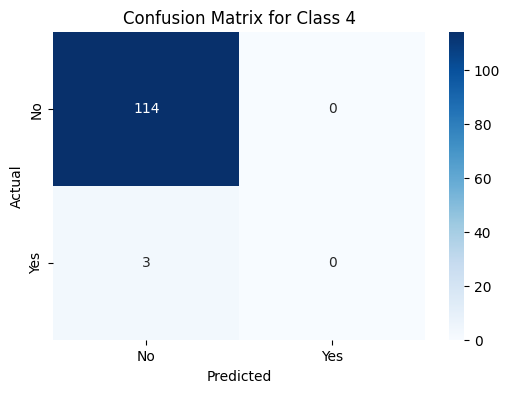

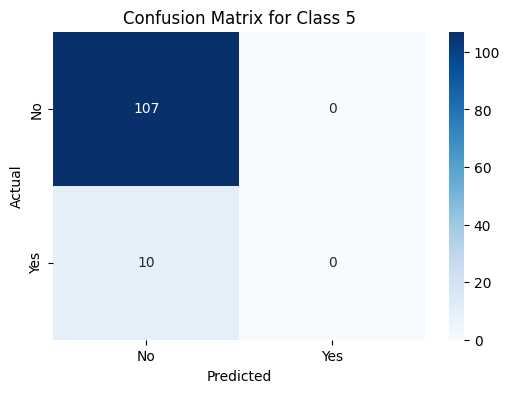

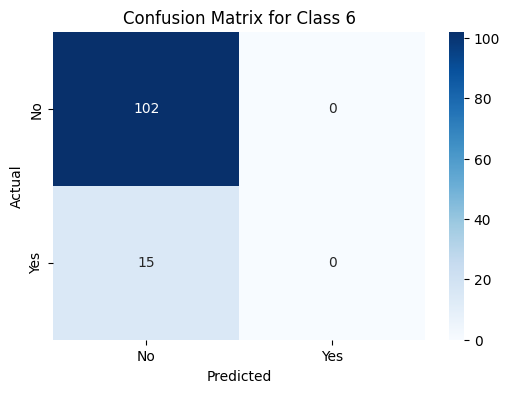

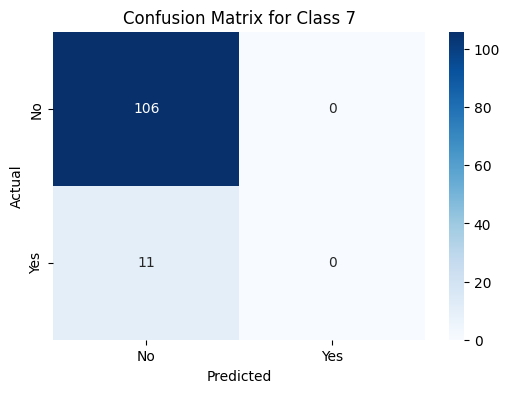

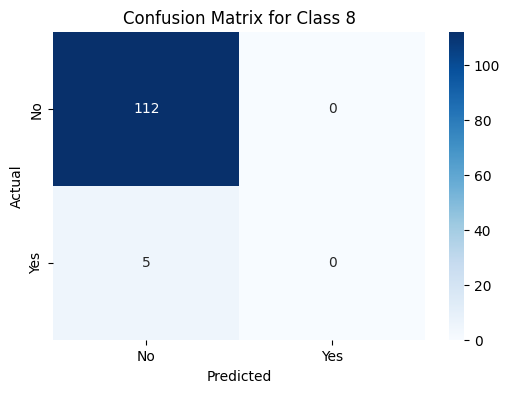

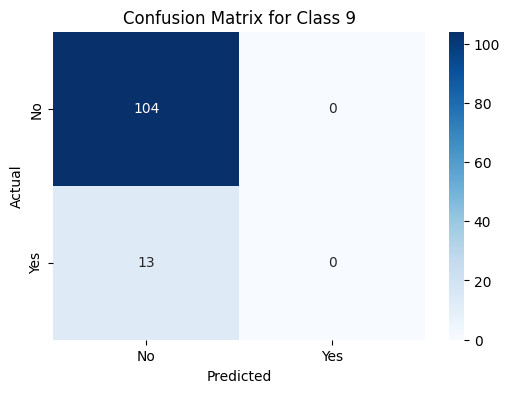

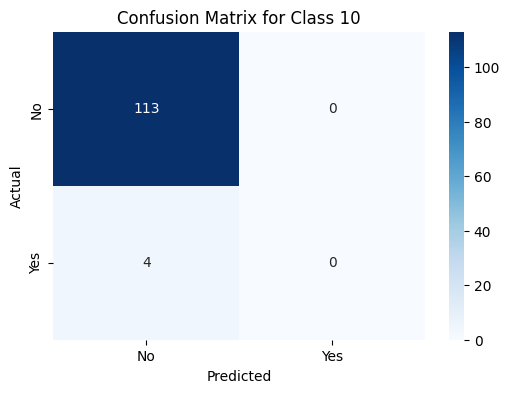

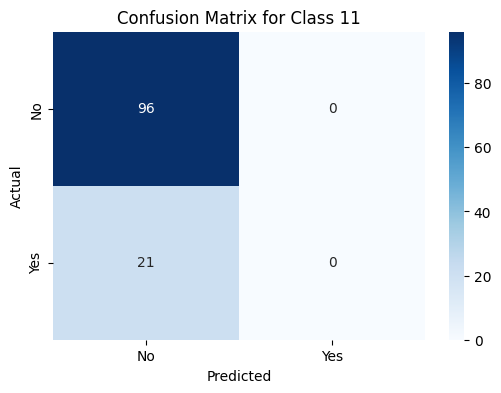

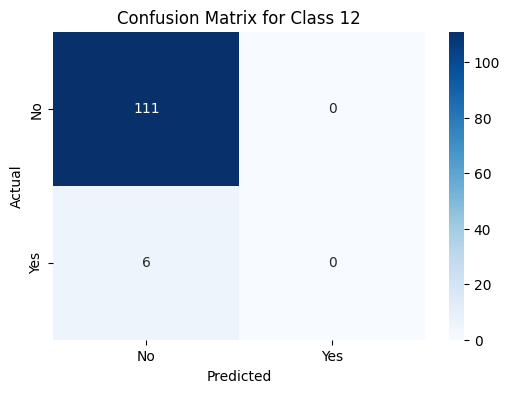

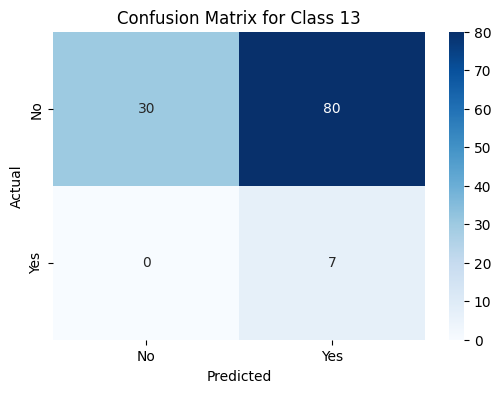

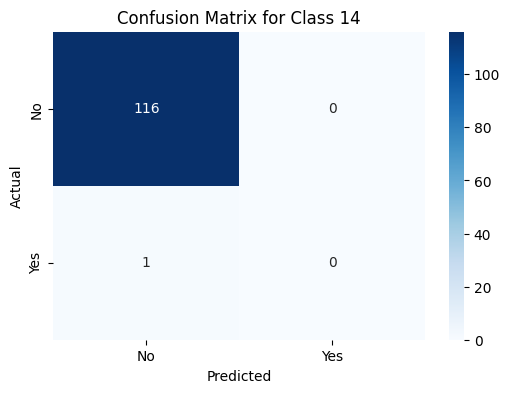

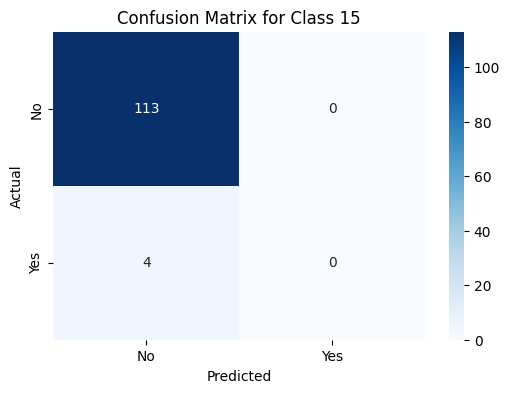

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for MobileNetV2_l2:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        15
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        13
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00        21
          12       0.00      0.00      0.00         6
          13       0.08      1.00      0.15         7
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         4

   micro avg       0.08      0.06    

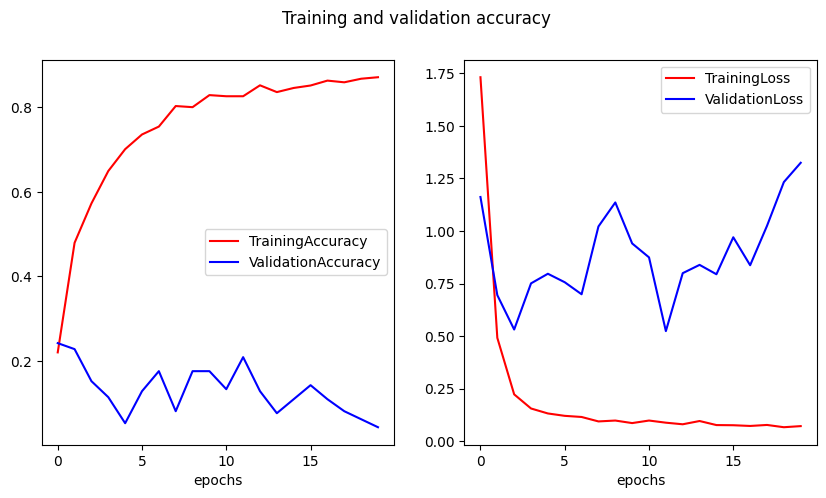

Training EfficientNetB0_l2...
Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.0910 - loss: 2.1813 - val_accuracy: 0.1422 - val_loss: 0.9005
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 519ms/step - accuracy: 0.2766 - loss: 0.5109 - val_accuracy: 0.0569 - val_loss: 0.7546
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 517ms/step - accuracy: 0.5259 - loss: 0.2068 - val_accuracy: 0.1422 - val_loss: 0.7102
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 516ms/step - accuracy: 0.6439 - loss: 0.1481 - val_accuracy: 0.0190 - val_loss: 0.7067
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 513ms/step - accuracy: 0.7228 - loss: 0.1239 - val_accuracy: 0.1090 - val_loss: 0.7013
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 507ms/step - accuracy: 0.7784 - loss: 0.1084 - val_accuracy: 0.0237 - val_loss: 0.4177
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 510ms/step - accuracy: 0.8048 - loss: 0.0977 - val_accuracy: 0.0237 - val_loss: 0.6454
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 514ms/step - accuracy: 0.81

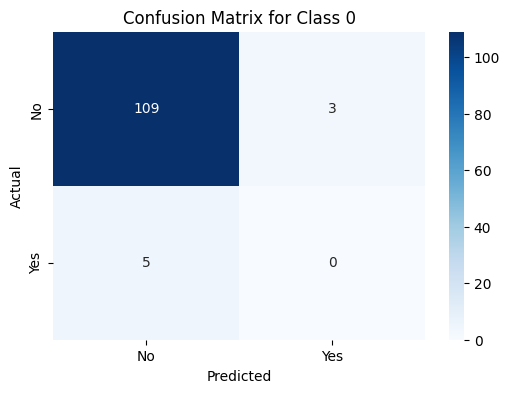

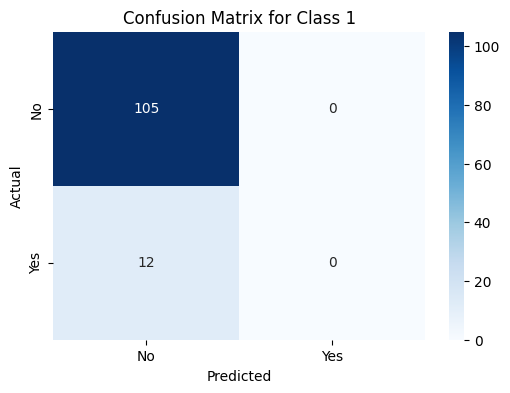

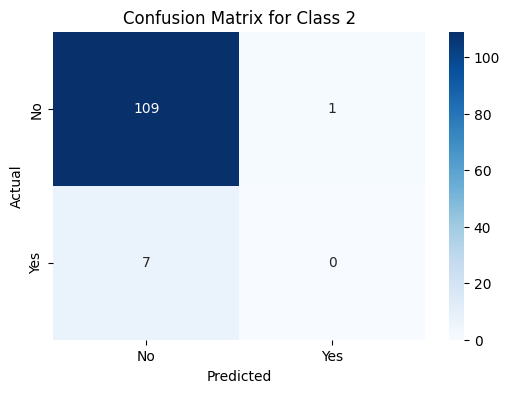

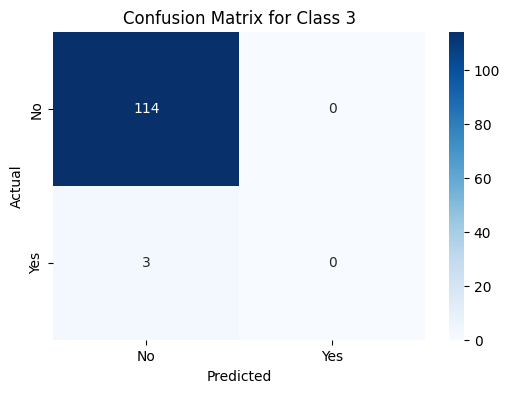

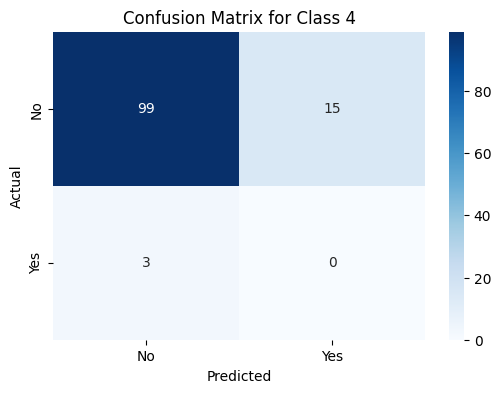

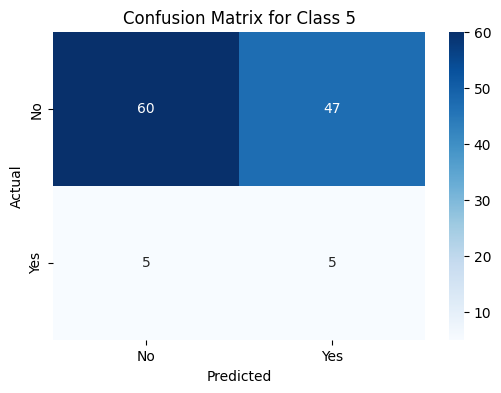

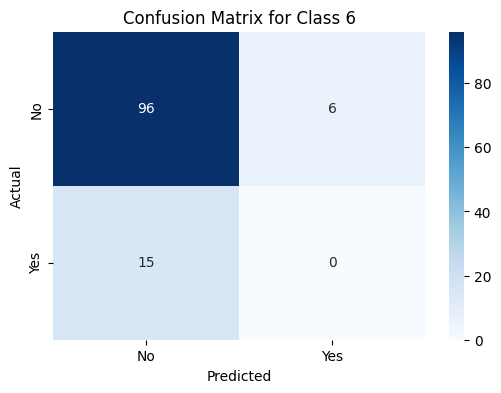

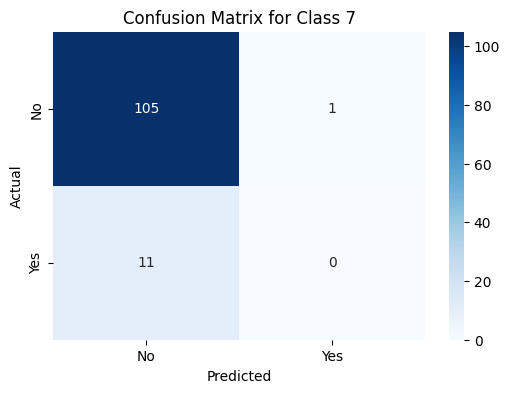

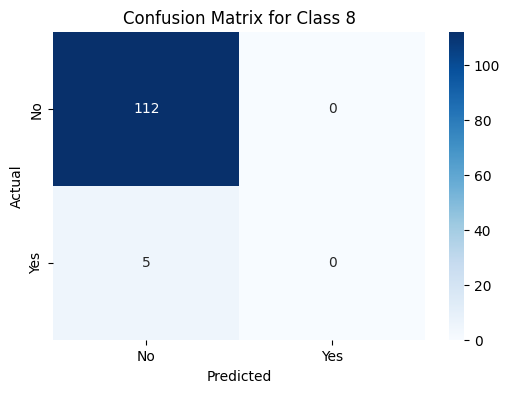

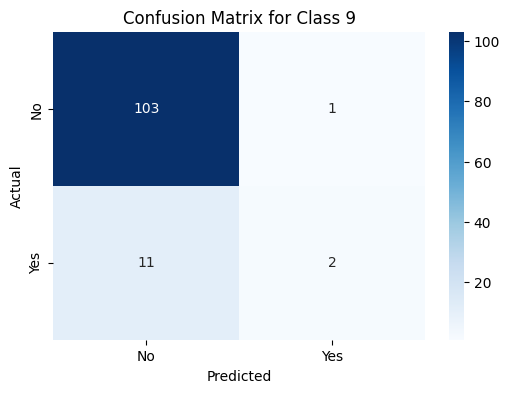

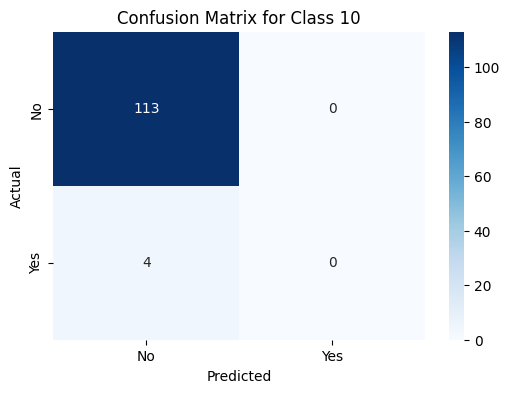

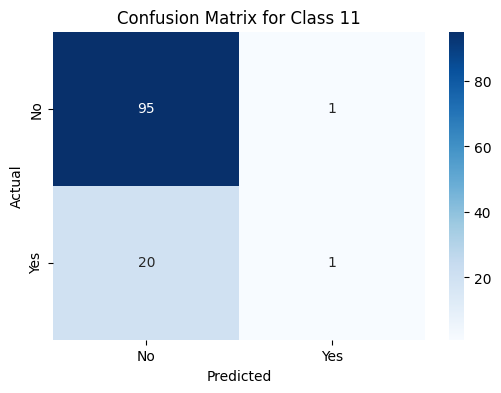

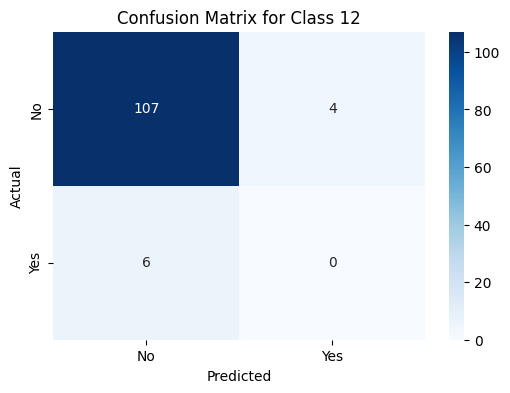

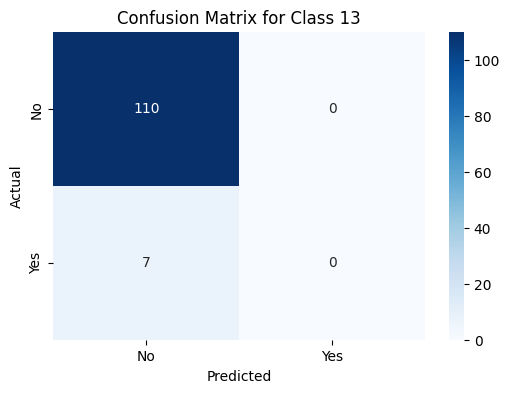

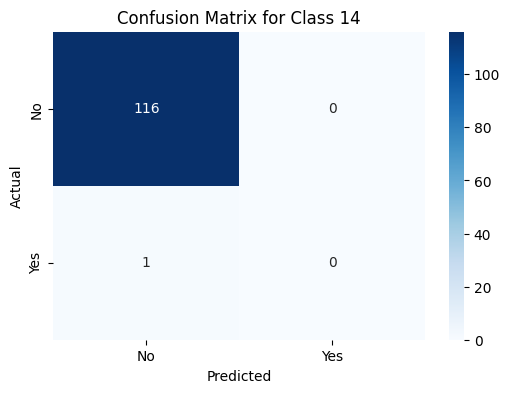

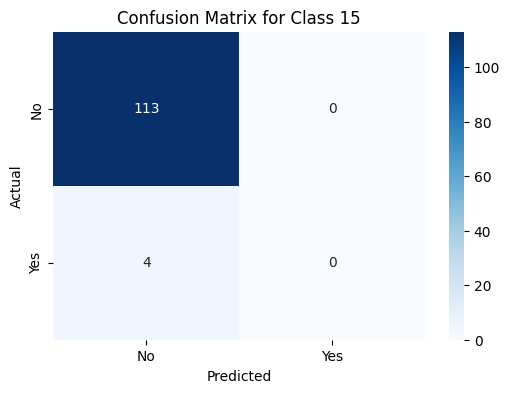

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for EfficientNetB0_l2:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.10      0.50      0.16        10
           6       0.00      0.00      0.00        15
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00         5
           9       0.67      0.15      0.25        13
          10       0.00      0.00      0.00         4
          11       0.50      0.05      0.09        21
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         4

   micro avg       0.09      0.06 

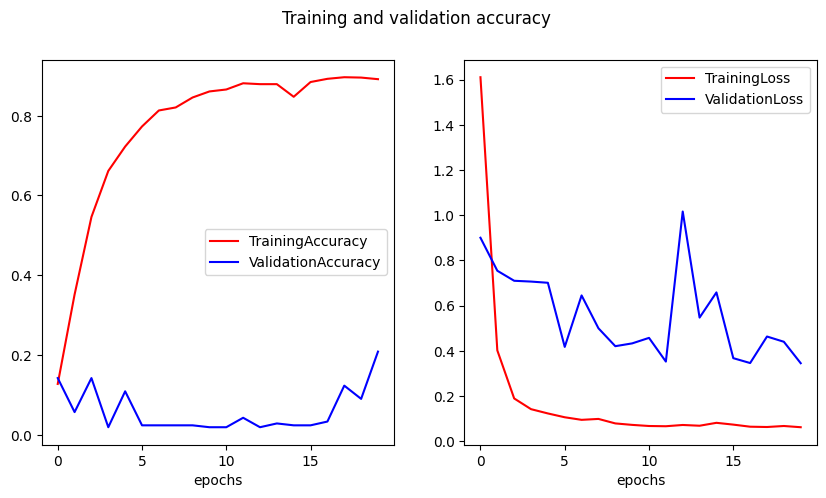

Training InceptionV3_l2...
Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.1559 - loss: 2.1422 - val_accuracy: 0.0664 - val_loss: 0.8565
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 706ms/step - accuracy: 0.4264 - loss: 0.4494 - val_accuracy: 0.1422 - val_loss: 0.3081
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 705ms/step - accuracy: 0.5503 - loss: 0.2003 - val_accuracy: 0.1517 - val_loss: 0.9488
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 700ms/step - accuracy: 0.5622 - loss: 0.1763 - val_accuracy: 0.2275 - val_loss: 0.2926
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 729ms/step - accuracy: 0.6136 - loss: 0.1602 - val_accuracy: 0.2227 - val_loss: 0.3885
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 696ms/step - accuracy: 0.6624 - loss: 0.1467 - val_accuracy: 0.4123 - val_loss: 0.2371
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 703ms/step - accuracy: 0.6547 - loss: 0.1581 - val_accuracy: 0.2891 - val_loss: 0.2378
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 703ms/step - accuracy: 0.6693 

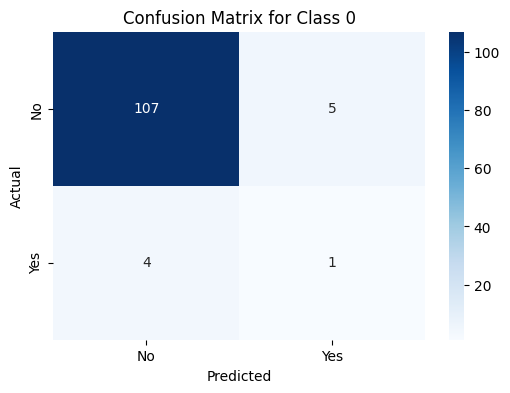

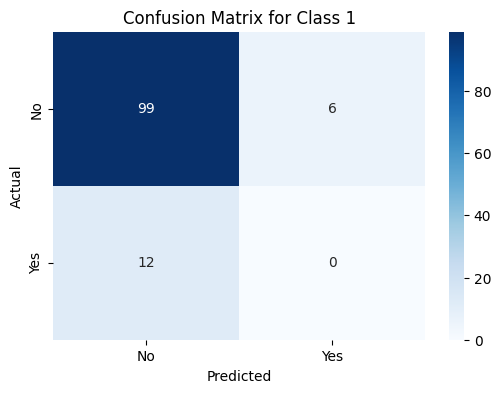

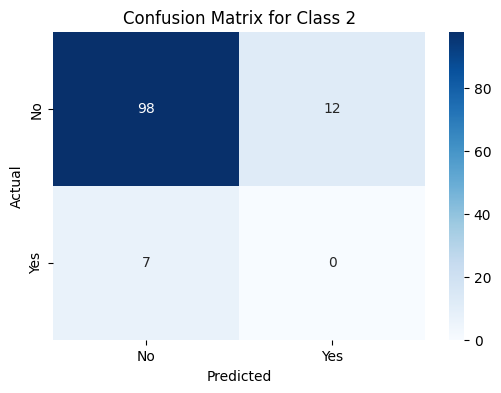

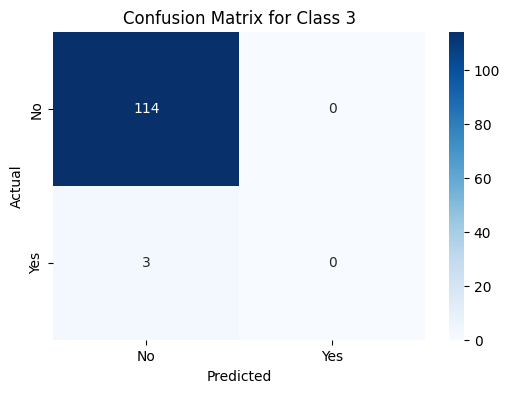

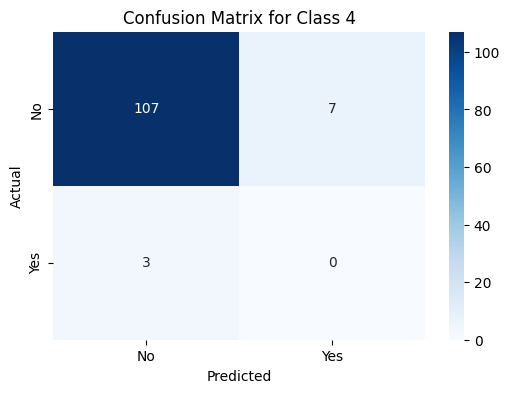

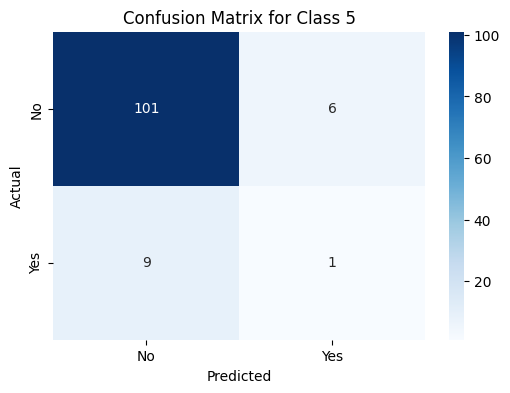

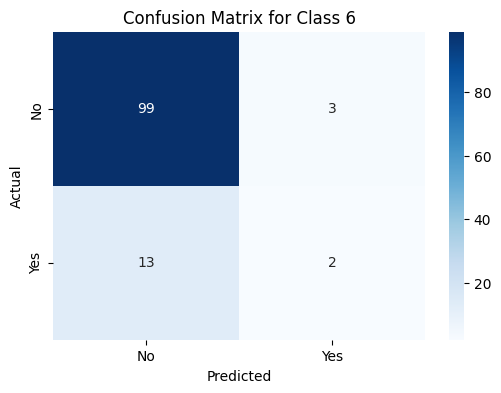

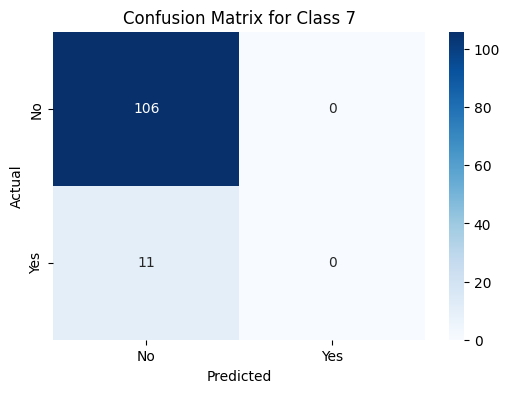

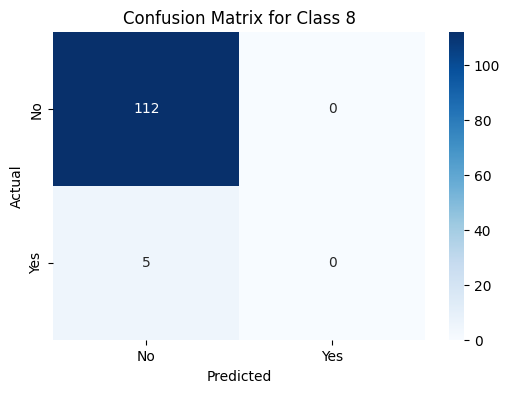

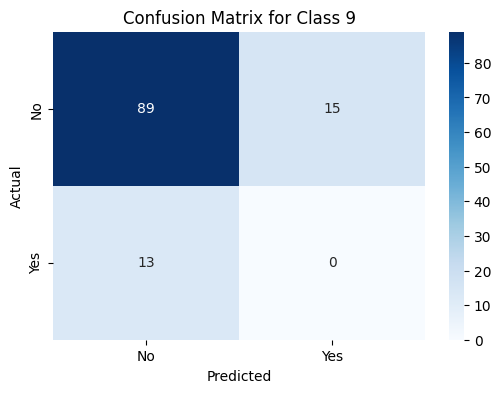

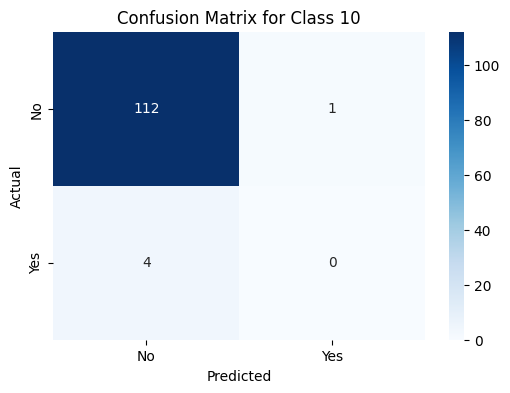

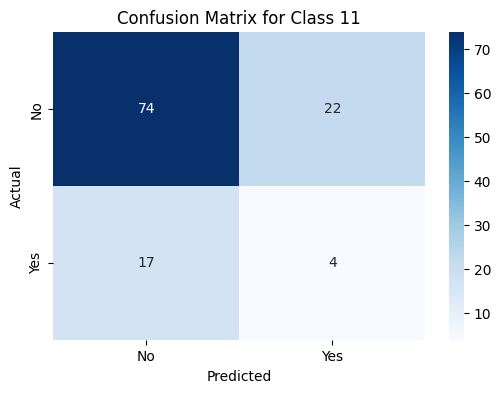

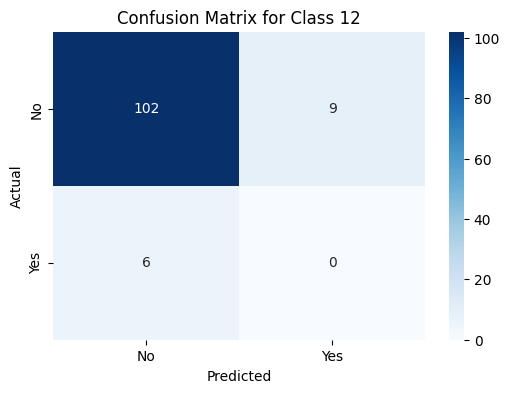

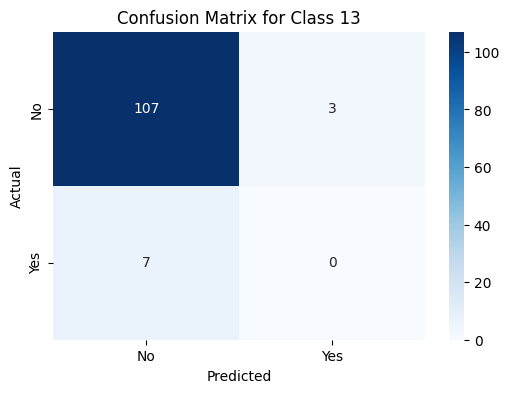

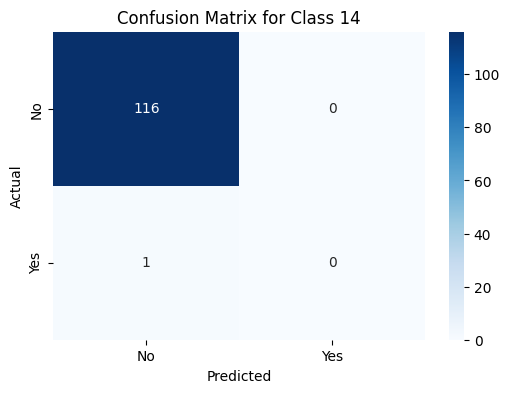

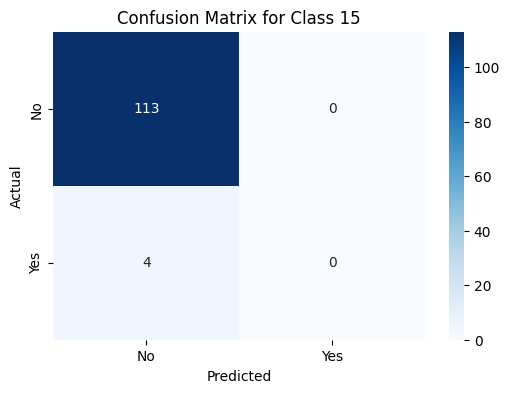

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for InceptionV3_l2:
               precision    recall  f1-score   support

           0       0.17      0.20      0.18         5
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.14      0.10      0.12        10
           6       0.40      0.13      0.20        15
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        13
          10       0.00      0.00      0.00         4
          11       0.15      0.19      0.17        21
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         4

   micro avg       0.08      0.06    

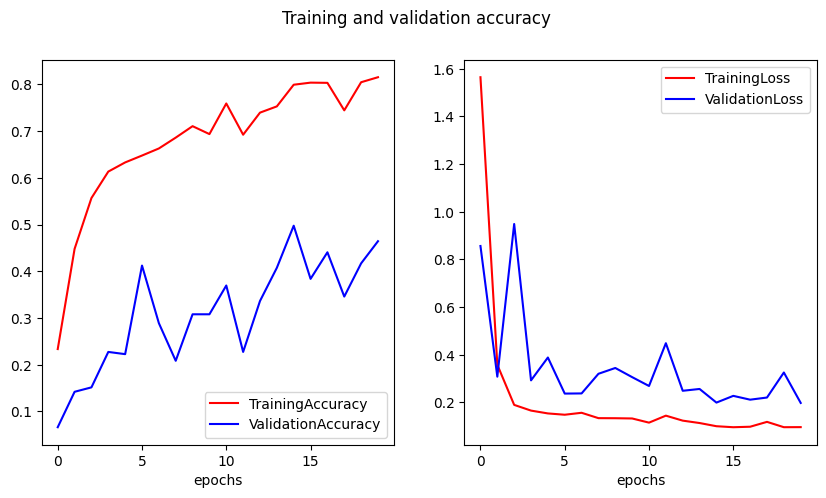

In [62]:
training(models_l2, train_dataset_ft, val_dataset_ft, test_dataset_ft)

# 9. Other Metric for Multi-label Classification

## 9.1 Transfer Model

In [13]:
evaluate_models = {
    'ResNet50': build_model(ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))),
    'MobileNetV2': build_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))),
    'EfficientNetB0': build_model(EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))),
    'InceptionV3': build_model(InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
}

# Load corresponding weights
evaluate_models['ResNet50'].load_weights("/kaggle/input/pretrained-weights/ResNet50_leaf_disease.h5")
evaluate_models['MobileNetV2'].load_weights("/kaggle/input/pretrained-weights/MobileNetV2_leaf_disease.h5")
evaluate_models['EfficientNetB0'].load_weights("/kaggle/input/pretrained-weights/EfficientNetB0_leaf_disease.h5")
evaluate_models['InceptionV3'].load_weights("/kaggle/input/pretrained-weights/InceptionV3_leaf_disease.h5")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, roc_auc_score

# Binary predictions from probabilities
def evaluate(y_true, y_pred):
    y_pred_sigmoid = (y_pred > 0.5).astype(int)

    # Metrics
    print("Subset Accuracy:", accuracy_score(y_true, y_pred_sigmoid))
    print("Hamming Loss:", hamming_loss(y_true, y_pred_sigmoid))
    print("F1 Score (micro):", f1_score(y_true, y_pred_sigmoid, average='micro'))
    print("F1 Score (macro):", f1_score(y_true, y_pred_sigmoid, average='macro'))
    print("ROC AUC (macro):", roc_auc_score(y_true, y_pred, average='macro'))

In [16]:
for name_model, model in evaluate_models.items():
    print(f'Evaluating {name_model}...')
    with tf.device('/GPU:0'):
         # Generate predictions
        y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)  # Extract labels
        y_pred = model.predict(test_dataset) 
        evaluate(y_true, y_pred)

Evaluating ResNet50...
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 7s/step
Subset Accuracy: 0.0
Hamming Loss: 0.06784188034188034
F1 Score (micro): 0.0
F1 Score (macro): 0.0
ROC AUC (macro): 0.5019743561060397
Evaluating MobileNetV2...
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 7s/step
Subset Accuracy: 0.07692307692307693
Hamming Loss: 0.08653846153846154
F1 Score (micro): 0.10989010989010987
F1 Score (macro): 0.06601660401002506
ROC AUC (macro): 0.5426199975398789
Evaluating EfficientNetB0...
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step
Subset Accuracy: 0.0
Hamming Loss: 0.06784188034188034
F1 Score (micro): 0.0
F1 Score (macro): 0.0
ROC AUC (macro): 0.48707536908644467
Evaluating InceptionV3...
2/2 ━━━━━━━━━━━━━━━━━━━━ 31s 15s/step
Subset Accuracy: 0.02564102564102564
Hamming Loss: 0.08386752136752136
F1 Score (micro): 0.05988023952095809
F1 Score (macro): 0.04455841588194529
ROC AUC (macro): 0.4815089397466451


## 9.2 Finetune

In [21]:
evaluate_models_ft = {
    'ResNet50_ft': build_model(ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)), fine_tune=True),
    'MobileNetV2_ft': build_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)), fine_tune=True),
    'EfficientNetB0_ft': build_model(EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)), fine_tune=True),
    'InceptionV3_ft': build_model(InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)), fine_tune=True)
}

# Load corresponding weights
evaluate_models_ft['ResNet50_ft'].load_weights("/kaggle/input/pretrained-weights/ResNet50_ft_leaf_disease.h5")
evaluate_models_ft['MobileNetV2_ft'].load_weights("/kaggle/input/pretrained-weights/MobileNetV2_ft_leaf_disease.h5")
evaluate_models_ft['EfficientNetB0_ft'].load_weights("/kaggle/input/pretrained-weights/EfficientNetB0_ft_leaf_disease.h5")
evaluate_models_ft['InceptionV3_ft'].load_weights("/kaggle/input/pretrained-weights/InceptionV3_ft_leaf_disease.h5")

In [22]:
for name_model, model in evaluate_models_ft.items():
    print(f'Evaluating {name_model}...')
    with tf.device('/GPU:0'):
         # Generate predictions
        y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)  # Extract labels
        y_pred = model.predict(test_dataset) 
        evaluate(y_true, y_pred)

Evaluating ResNet50_ft...
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
Subset Accuracy: 0.02564102564102564
Hamming Loss: 0.140491452991453
F1 Score (micro): 0.05054151624548736
F1 Score (macro): 0.02004105445116681
ROC AUC (macro): 0.4907348121746897
Evaluating MobileNetV2_ft...
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Subset Accuracy: 0.03418803418803419
Hamming Loss: 0.07959401709401709
F1 Score (micro): 0.050955414012738856
F1 Score (macro): 0.018939393939393943
ROC AUC (macro): 0.4793055956602468
Evaluating EfficientNetB0_ft...
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step
Subset Accuracy: 0.07692307692307693
Hamming Loss: 0.11164529914529915
F1 Score (micro): 0.07929515418502202
F1 Score (macro): 0.03680926916221034
ROC AUC (macro): 0.496560076803163
Evaluating InceptionV3_ft...
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step
Subset Accuracy: 0.10256410256410256
Hamming Loss: 0.10737179487179487
F1 Score (micro): 0.11453744493392072
F1 Score (macro): 0.041109625668449196
ROC AUC (macro): 0.4887238111483705


In [23]:
evaluate_models_l2 = {
    'ResNet50_l2': build_model(ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)), fine_tune=True, regular=True),
    'MobileNetV2_l2': build_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)), fine_tune=True, regular=True),
    'EfficientNetB0_l2': build_model(EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)), fine_tune=True, regular=True),
    'InceptionV3_l2': build_model(InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)), fine_tune=True, regular=True)
}

# Load corresponding weights
evaluate_models_l2['ResNet50_l2'].load_weights("/kaggle/input/pretrained-weights/ResNet50_l2_leaf_disease.h5")
evaluate_models_l2['MobileNetV2_l2'].load_weights("/kaggle/input/pretrained-weights/MobileNetV2_l2_leaf_disease.h5")
evaluate_models_l2['EfficientNetB0_l2'].load_weights("/kaggle/input/pretrained-weights/EfficientNetB0_l2_leaf_disease.h5")
evaluate_models_l2['InceptionV3_l2'].load_weights("/kaggle/input/pretrained-weights/InceptionV3_l2_leaf_disease.h5")

In [24]:
for name_model, model in evaluate_models_l2.items():
    print(f'Evaluating {name_model}...')
    with tf.device('/GPU:0'):
         # Generate predictions
        y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)  # Extract labels
        y_pred = model.predict(test_dataset) 
        evaluate(y_true, y_pred)

Evaluating ResNet50_l2...
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
Subset Accuracy: 0.03418803418803419
Hamming Loss: 0.1047008547008547
F1 Score (micro): 0.0392156862745098
F1 Score (macro): 0.0196969696969697
ROC AUC (macro): 0.48000914118757404
Evaluating MobileNetV2_l2...
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Subset Accuracy: 0.03418803418803419
Hamming Loss: 0.1047008547008547
F1 Score (micro): 0.04854368932038835
F1 Score (macro): 0.007267441860465117
ROC AUC (macro): 0.4683648910255793
Evaluating EfficientNetB0_l2...
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step
Subset Accuracy: 0.05128205128205128
Hamming Loss: 0.09882478632478632
F1 Score (micro): 0.06091370558375634
F1 Score (macro): 0.039848303870043
ROC AUC (macro): 0.5051756320671266
Evaluating InceptionV3_l2...
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step
Subset Accuracy: 0.07692307692307693
Hamming Loss: 0.11271367521367522
F1 Score (micro): 0.0944206008583691
F1 Score (macro): 0.051433571910545595
ROC AUC (macro): 0.4928210129077677
